<a href="https://colab.research.google.com/github/pedrobslima/proj-respAI/blob/main/respAI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv

min 8 features úteis (o menor num dentre os datasets utilizados em aula, diabetes)

### Especificações

1. Escolha uma base de dados do seu interesse e construa modelos preditivos.

2. Trabalhe agora com os dois aspectos principais explorados em sala:

  - (a) Interpretabilidade: discuta o que o modelo aprendeu, como ele realiza suas predições, quais as variáveis mais importantes,... dentre outros aspectos que ajude a entender o comportamento do modelo enquanto realiza suas predições.   

  - (b) Confiabilidade: qual o desempenho preditivo do modelo, em que situações ele falha, em que situações tem o seu melhor desempenho,... dentre outros pontos que ajude a entender quando confiar as predições do modelo.

- Obs. 1: utilize uma base de dados nova, não usada nas aulas;

- Obs. 2: a entrega será feita com:

  - (a) um notebook comentado com os insights obtidos pela equipe. Mais que gerar gráficos e estatísticas, é importante que se analise os resultados obtidos e que se apontem as conclusões mais importantes.

  - (b) um pequeno vídeo até 10 minutos descrevendo o que foi produzido no notebook.

### Dicionário dataset
* battery_power: Total energy a battery can store in one time measured in mAh
* blue: Has bluetooth or not
* clock_speed: speed at which microprocessor executes instructions
* dual_sim: Has dual sim support or not
* fc: Front Camera mega pixels
* four_g: Has 4G or not
* int_memory: Internal Memory in Gigabytes
* m_dep: Mobile Depth in cm
* mobile_wt: Weight of mobile phone
* n_cores: Number of cores of processor
* pc: Primary Camera mega pixels
* px_height: Pixel Resolution Height
* px_width: Pixel Resolution Width
* ram: Random Access Memory in Mega Bytes
* sc_h: Screen Height of mobile in cm
* sc_w: Screen Width of mobile in cm
* talk_time: longest time that a single battery charge will last when you are
* three_g: Has 3G or not
* touch_screen: Has touch screen or not
* wifi: Has wifi or not
---
* price_range: The target variable with value:
  * 0: low cost
  * 1: medium cost
  * 2: high cost
  * 3: very high cost

### Imports

In [374]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay as pdp
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from random import randint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import log2
import graphviz

### ProbPoolArray()
class of probability pool array

In [548]:
class ProbPoolArray():
  def __init__(self, num_samples: int, kclasses: int = 4, base_list: list = None):
    self.list_prob = [] # list_prob[instance][model][class]
    self.num_samples = num_samples
    self.kclasses = kclasses
    if(base_list):
      self.t_models = len(base_list[0])
      self.list_prob = base_list
    else:
      self.t_models = 0
      for i in range(self.num_samples):
        self.list_prob.append([])

  def __repr__(self):
    printstr = ""
    for i in range(self.num_samples):
      printstr += f"Instância x{i}:\n"
      for t in range(self.t_models):
        printstr += f"t{t+1}: {self.list_prob[i][t]}\n"
    return printstr

  def __getitem__(self, idx):
    return self.list_prob[idx]

  def __len__(self):
    return len(self.num_samples)

  def add(self, modelPreds: np.ndarray):
    '''Para adicionar as predições de probabilidade de classe para instâncias, feitas por um modelo.'''
    if(modelPreds.shape == (self.num_samples, self.kclasses)):
      for i in range(self.num_samples):
        self.list_prob[i].append(modelPreds[i])
      self.t_models += 1
    else:
      print(f"[Erro] O número de instâncias do modelo adicionado é diferente ({len(modelPreds)}) do padrão estabelecido ({self.num_samples})")

  def predEntropy(self, idx: int = None, df: bool = False, operation: str = 'mean') -> list | pd.DataFrame:
    '''Predicted Entropy: Entropia da probabilidade estimada pela média das probs do pool'''
    predEntropy = []
    if(idx is not None):
      models = [idx]
    else:
      models = range(self.t_models)
    for instancia in self.list_prob:
      ksum = 0
      for k in range(self.kclasses):
        probEstm = []
        for t in models:
          probEstm.append(instancia[t][k])
        meanProb = np.mean(probEstm)
        if(meanProb != 0):
          ksum += meanProb * log2(meanProb)
      predEntropy.append(-ksum)
    if(df):
      return pd.DataFrame(predEntropy, columns=['entropia'])
    return predEntropy

  def expcEntropy(self,  idx: int = None, df: bool = False, operation: str = 'mean') -> list | pd.DataFrame:
    '''[RANDÔMICA]
    Expected Entropy: média das entropias do pool de modelos'''
    expcEntropy = [] # lista da entropia das instâncias
    if(idx is not None):
      models = [idx]
    else:
      models = range(self.t_models)
    for instancia in self.list_prob:
      #tsum = 0
      lista = []
      for t in models:
        entropy = 0
        for k in range(self.kclasses):
          a_t = float(instancia[t][k])
          if(a_t != 0):
            entropy += a_t * log2(a_t)
        #tsum -= entropy
        lista.append(-entropy)
      if(operation in ['mean', 'media', 'média']):
        expcEntropy.append(sum(lista)/len(models))
      elif(operation in ['std', 'desvio padrao', 'desvio padrão']):
        expcEntropy.append(np.std(lista))
    if(df):
        return pd.DataFrame(expcEntropy, columns=['entropia'])
    return expcEntropy

  def mutualInfo(self, idx: int = None, df: bool = False) -> list:
    '''[EPISTÊMICA]
    Mutual Information: Predicted Entropy - Expected Entropy'''
    mutual = []
    pred = self.predEntropy(idx=idx)
    expc = self.expcEntropy(idx=idx)
    for i in range(self.num_samples):
      mutual.append(pred[i] - expc[i])
    if(df):
        return pd.DataFrame(mutual, columns=['entropia'])
    return mutual



---



### dataset (df)

In [376]:
df = pd.read_csv("/content/mobile_price.csv")

In [377]:
df

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842     0          2.2         0   1       0           7   
1              1021     1          0.5         1   0       1          53   
2               563     1          0.5         1   2       1          41   
3               615     1          2.5         0   0       0          10   
4              1821     1          1.2         0  13       1          44   
...             ...   ...          ...       ...  ..     ...         ...   
1995            794     1          0.5         1   0       1           2   
1996           1965     1          2.6         1   0       0          39   
1997           1911     0          0.9         1   1       1          36   
1998           1512     0          0.9         0   4       1          46   
1999            510     1          2.0         1   5       1          45   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  \
0       0.6        188        2  ...         20       756  2549     9     7   
1       0.7        136        3  ...        905      1988  2631    17     3   
2       0.9        145        5  ...       1263      1716  2603    11     2   
3       0.8        131        6  ...       1216      1786  2769    16     8   
4       0.6        141        2  ...       1208      1212  1411     8     2   
...     ...        ...      ...  ...        ...       ...   ...   ...   ...   
1995    0.8        106        6  ...       1222      1890   668    13     4   
1996    0.2        187        4  ...        915      1965  2032    11    10   
1997    0.7        108        8  ...        868      1632  3057     9     1   
1998    0.1        145        5  ...        336       670   869    18    10   
1999    0.9        168        6  ...        483       754  3919    19     4   

      talk_time  three_g  touch_screen  wifi  price_range  
0            19        0             0     1            1  
1             7        1             1     0            2  
2             9        1             1     0            2  
3            11        1             0     0            2  
4            15        1             1     0            1  
...         ...      ...           ...   ...          ...  
1995         19        1             1     0            0  
1996         16        1             1     1            2  
1997          5        1             1     0            3  
1998         19        1             1     1            0  
1999          2        1             1     1            3  

[2000 rows x 21 columns]

In [378]:
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

<Axes: >

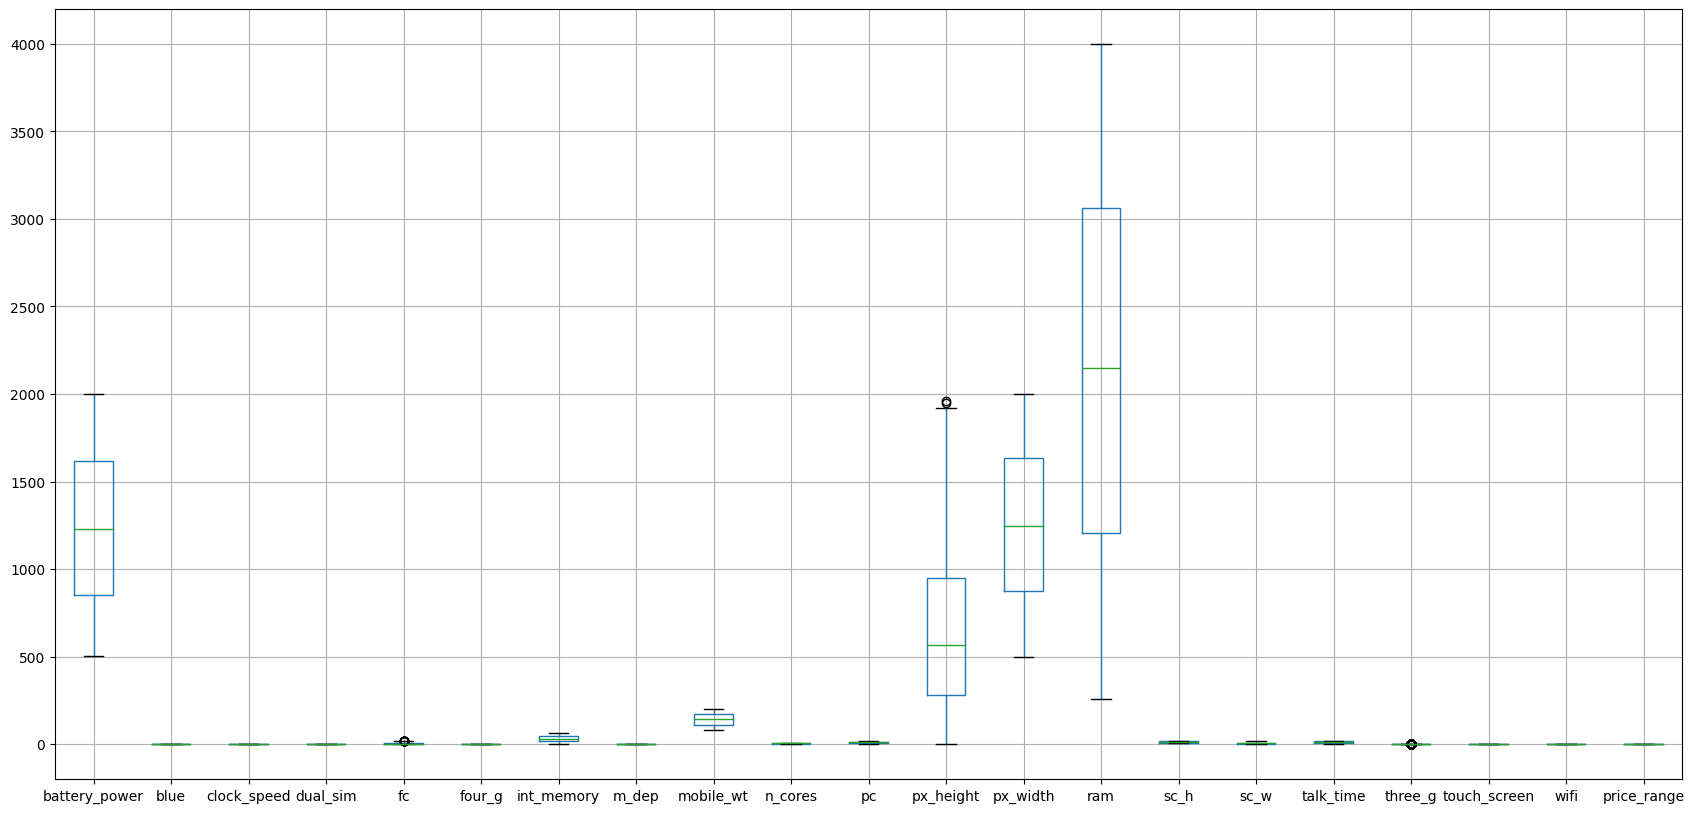

In [379]:
df.boxplot(figsize=(21,10))

In [380]:
X = df.drop(columns=['price_range'])
y = df['price_range'] #.astype('category')

shuffle_seed = randint(0, 4294967295)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=shuffle_seed)

In [381]:
y.value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

In [382]:
display_labels = ['Baixo', 'Médio', 'Alto', 'Mto alto']

In [383]:
NUM_SAMPLES = len(X_test)
probpool = ProbPoolArray(NUM_SAMPLES)

### dataset 1.5 (df_norm)

In [384]:
df.min(), df.max()

(battery_power    501.0
 blue               0.0
 clock_speed        0.5
 dual_sim           0.0
 fc                 0.0
 four_g             0.0
 int_memory         2.0
 m_dep              0.1
 mobile_wt         80.0
 n_cores            1.0
 pc                 0.0
 px_height          0.0
 px_width         500.0
 ram              256.0
 sc_h               5.0
 sc_w               0.0
 talk_time          2.0
 three_g            0.0
 touch_screen       0.0
 wifi               0.0
 price_range        0.0
 dtype: float64,
 battery_power    1998.0
 blue                1.0
 clock_speed         3.0
 dual_sim            1.0
 fc                 19.0
 four_g              1.0
 int_memory         64.0
 m_dep               1.0
 mobile_wt         200.0
 n_cores             8.0
 pc                 20.0
 px_height        1960.0
 px_width         1998.0
 ram              3998.0
 sc_h               19.0
 sc_w               18.0
 talk_time          20.0
 three_g             1.0
 touch_screen        1.0
 wif

In [385]:
df_norm = df.copy()
cols = ['mobile_wt', 'battery_power', 'px_height', 'px_width', 'ram'] # df_norm.drop(columns=['price_range']).columns
#scaler = MinMaxScaler()
for c in cols:
  scaler = MinMaxScaler((df[c].min()/100, df[c].max()/100))
  df_norm[c] = scaler.fit_transform(np.array(df_norm[c]).reshape(-1, 1))

<Axes: >

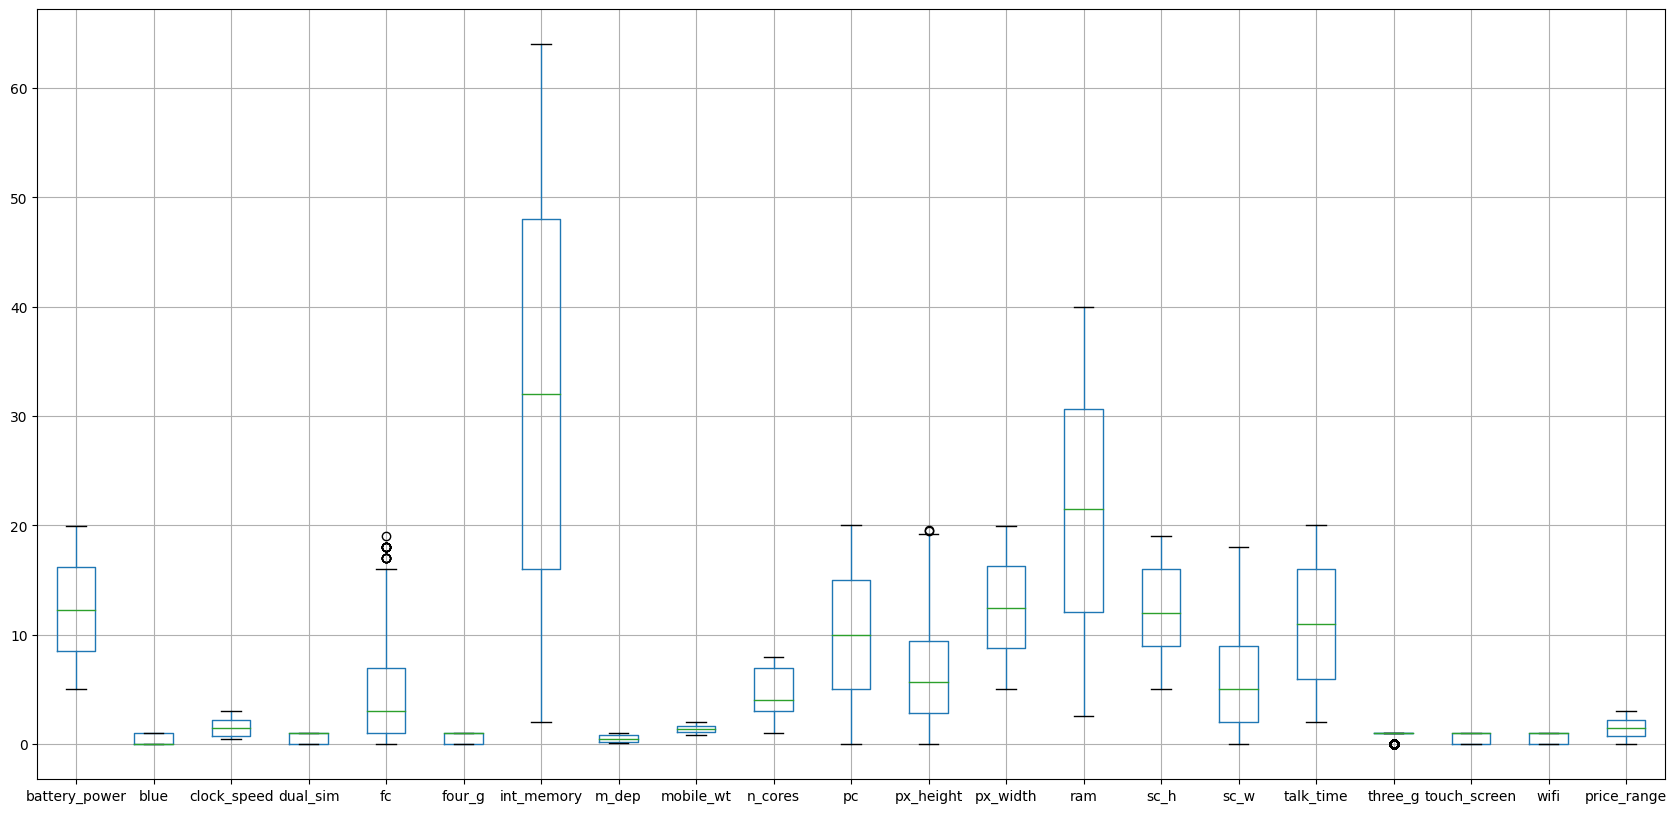

In [386]:
df_norm.boxplot(figsize=(21,10))

In [387]:
Xt = df_norm.drop(columns=['price_range'])

X_ntrain, X_ntest, y_ntrain, y_ntest = train_test_split(Xt, y, test_size=0.25, shuffle=True, random_state=shuffle_seed)

### dataset 2 (dfram)

In [388]:
dfram = df_norm.drop(columns=['ram']).copy()

Xram = dfram.drop(columns=['price_range'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xram, y, test_size=0.25, shuffle=True, random_state=shuffle_seed)

In [389]:
Xram_norm = Xram.copy()
cols = ['mobile_wt', 'battery_power', 'px_height', 'px_width'] # df_norm.drop(columns=['price_range']).columns
#scaler = MinMaxScaler()
for c in cols:
  scaler = MinMaxScaler((df[c].min()/100, df[c].max()/100))
  Xram_norm[c] = scaler.fit_transform(np.array(df_norm[c]).reshape(-1, 1))

X_ntrain2, X_ntest2, y_ntrain2, y_ntest2 = train_test_split(Xram_norm, y, test_size=0.25, shuffle=True, random_state=shuffle_seed)

In [390]:
probpool2 = ProbPoolArray(NUM_SAMPLES)

### dataset 3 (ram)

In [391]:
ram = df[['ram']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(ram, y, test_size=0.25, shuffle=True, random_state=shuffle_seed)

In [392]:
probpool3 = ProbPoolArray(NUM_SAMPLES)

### Functions

In [393]:
def checkMetrics(test, pred, display=None):
  global y
  labels = np.sort(y.unique())
  print(f"Acurácia: {accuracy_score(test, pred)}")
  print(f"Precisão: {precision_score(test, pred, labels=labels, average='macro')}")
  print(f"Recall: {recall_score(test, pred, labels=labels, average='macro')}")
  print(f"F1-Score: {f1_score(test, pred, labels=labels, average='macro')}")
  print("Matriz de Confusão:")

  cm = confusion_matrix(test, pred, labels=labels)

  if(display):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display)
  else:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

  disp.plot()

  plt.show()

In [394]:
def pfi(model, x, y, name=None):
  result = permutation_importance(model, x, y,n_repeats=30, random_state=0)

  cols = [f"[{i}] - {x.columns[i]}" for i in range(len(x.columns))]

  importances = pd.Series(result.importances_mean, index=cols)

  fig, ax = plt.subplots()

  importances.plot.bar(yerr=result.importances_std, ax=ax)

  if(name):
    ax.set_title(f"Feature importances on {name} model")
  else:
    name = str(model)
    i = name.find('(')
    ax.set_title(f"Feature importances on {name[:i]} model\n{name[i:]}")
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

In [395]:
def pdpClasses(model, x, features: list, res: int = 10, classes: list=[0,1,2,3]):
  global display_labels
  for idx in classes:
    pdp.from_estimator(model, x, features, target=idx, grid_resolution=res)
    plt.title(display_labels[idx])
  plt.show()

In [396]:
def pdp2versions(model_list: list | tuple, x_list: list | tuple, features: list, res: int = 10, classes: list=[0,1,2,3], axis:int=0):
  if(axis==0):
    for idx in classes:
      for i, (model, xt) in enumerate(zip(model_list, x_list)):
        name = str(model)
        print(f'\n{name[:name.find("(")]} {i+1}:')
        if(len(xt.columns) != 1):
          pdpClasses(model=model, x=xt, features=features, res=res, classes=[idx])
        else:
          pdpClasses(model=model, x=xt, features=[0], res=res, classes=[idx])
      print('\n'+"-"*60+'\n'+"-"*60)
  elif(axis==1):
    for i, (model, xt) in enumerate(zip(model_list, x_list)):
      name = str(model)
      print(f'\n{name[:name.find("(")]} {i+1}:')
      for idx in classes:
        if(len(xt.columns) != 1):
          pdpClasses(model=model, x=xt, features=features, res=res, classes=[idx])
        else:
          pdpClasses(model=model, x=xt, features=[0], res=res, classes=[idx])
      print('\n'+"-"*60+'\n'+"-"*60)
  else:
    print('axis deve ser igual a 0 ou 1')

In [397]:
len(X_train3.columns)

1

# Models

## **Decision Trees**

### **LEARNING THE DECISION TREE CLASSIFIER**

In [398]:
dtree = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=50).fit(X_train, y_train)

[Text(0.4740566037735849, 0.9166666666666666, 'ram <= 2231.5\nentropy = 2.0\nsamples = 1500\nvalue = [376, 376, 372, 376]\nclass = y[0]'),
 Text(0.19811320754716982, 0.75, 'ram <= 1103.0\nentropy = 1.342\nsamples = 774\nvalue = [376, 329, 69, 0]\nclass = y[0]'),
 Text(0.09433962264150944, 0.5833333333333334, 'px_height <= 1058.5\nentropy = 0.529\nsamples = 342\nvalue = [301, 41, 0, 0]\nclass = y[0]'),
 Text(0.05660377358490566, 0.4166666666666667, 'battery_power <= 1837.0\nentropy = 0.305\nsamples = 275\nvalue = [260, 15, 0, 0]\nclass = y[0]'),
 Text(0.03773584905660377, 0.25, 'ram <= 835.5\nentropy = 0.121\nsamples = 244\nvalue = [240, 4, 0, 0]\nclass = y[0]'),
 Text(0.018867924528301886, 0.08333333333333333, 'entropy = 0.0\nsamples = 168\nvalue = [168, 0, 0, 0]\nclass = y[0]'),
 Text(0.05660377358490566, 0.08333333333333333, 'entropy = 0.297\nsamples = 76\nvalue = [72, 4, 0, 0]\nclass = y[0]'),
 Text(0.07547169811320754, 0.25, 'entropy = 0.938\nsamples = 31\nvalue = [20, 11, 0, 0]\nc

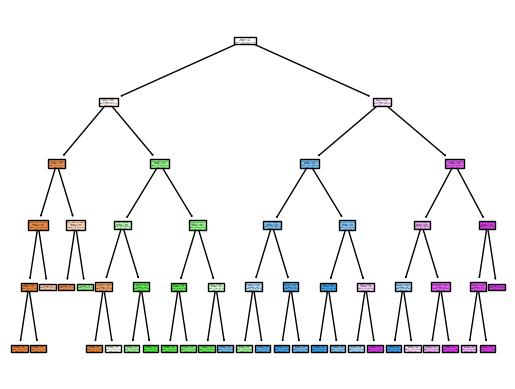

In [399]:
tree.plot_tree(dtree, feature_names = X.columns, class_names=True,filled = True)

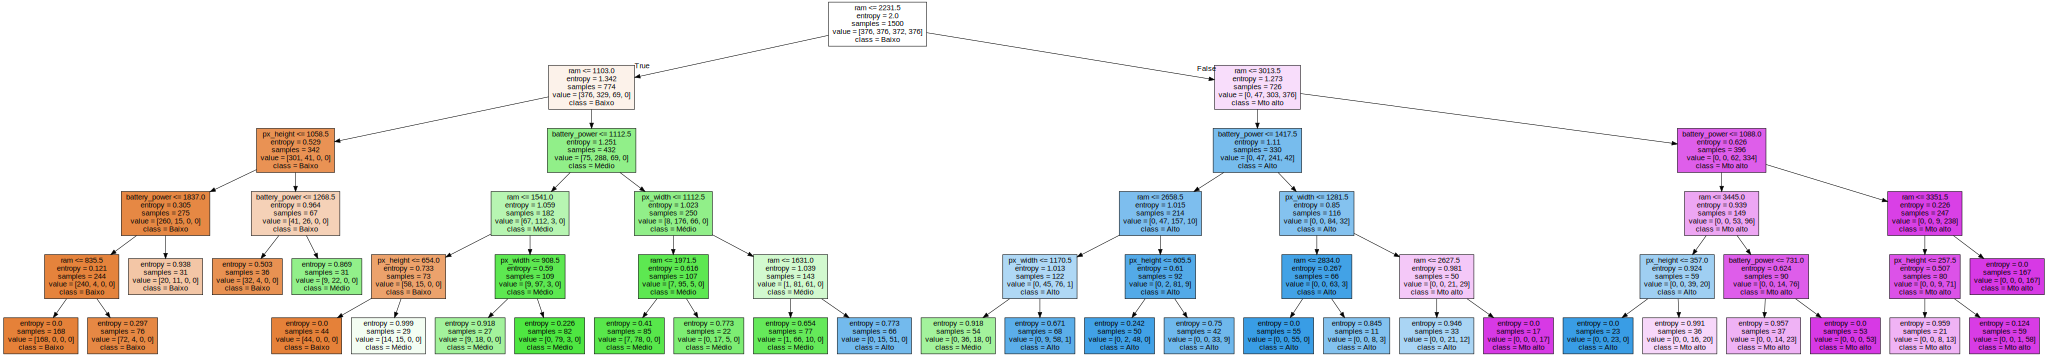

In [400]:
# DOT data
dot_data = tree.export_graphviz(dtree, out_file=None,
                                feature_names=X_train.columns,
                                class_names=display_labels,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf")
graph

In [401]:
graph.render("dtree")

'dtree.pdf'

Acurácia: 0.822
Precisão: 0.8240673523678118
Recall: 0.823210685483871
F1-Score: 0.8221332760936344
Matriz de Confusão:


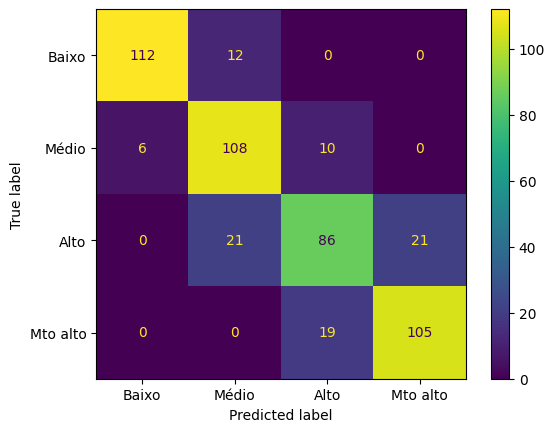

In [402]:
y_preddt1 = dtree.predict(X_test)
checkMetrics(y_test, y_preddt1, display=display_labels)

In [403]:
probpool.add(dtree.predict_proba(X_test))



---


### **LEARNING THE DECISION TREE CLASSIFIER 2**

In [404]:
dtree2 = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=50).fit(X_train2, y_train2)

[Text(0.5657894736842105, 0.9166666666666666, 'battery_power <= 13.11\nentropy = 2.0\nsamples = 1500\nvalue = [376, 376, 372, 376]\nclass = y[0]'),
 Text(0.2894736842105263, 0.75, 'px_width <= 14.575\nentropy = 1.969\nsamples = 808\nvalue = [255, 204, 209, 140]\nclass = y[0]'),
 Text(0.14473684210526316, 0.5833333333333334, 'int_memory <= 30.5\nentropy = 1.913\nsamples = 514\nvalue = [185, 137, 128, 64]\nclass = y[0]'),
 Text(0.07894736842105263, 0.4166666666666667, 'sc_w <= 19.5\nentropy = 1.81\nsamples = 245\nvalue = [102, 54, 70, 19]\nclass = y[0]'),
 Text(0.05263157894736842, 0.25, 'int_memory <= 25.5\nentropy = 1.779\nsamples = 236\nvalue = [99, 52, 70, 15]\nclass = y[0]'),
 Text(0.02631578947368421, 0.08333333333333333, 'entropy = 1.827\nsamples = 194\nvalue = [76, 46, 57, 15]\nclass = y[0]'),
 Text(0.07894736842105263, 0.08333333333333333, 'entropy = 1.4\nsamples = 42\nvalue = [23, 6, 13, 0]\nclass = y[0]'),
 Text(0.10526315789473684, 0.25, 'entropy = 1.53\nsamples = 9\nvalue = 

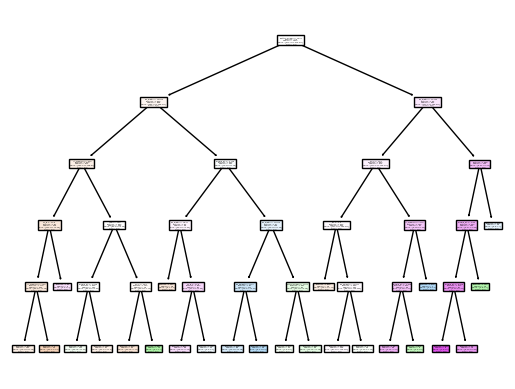

In [405]:
tree.plot_tree(dtree2, feature_names = X.columns, class_names=True,filled = True)

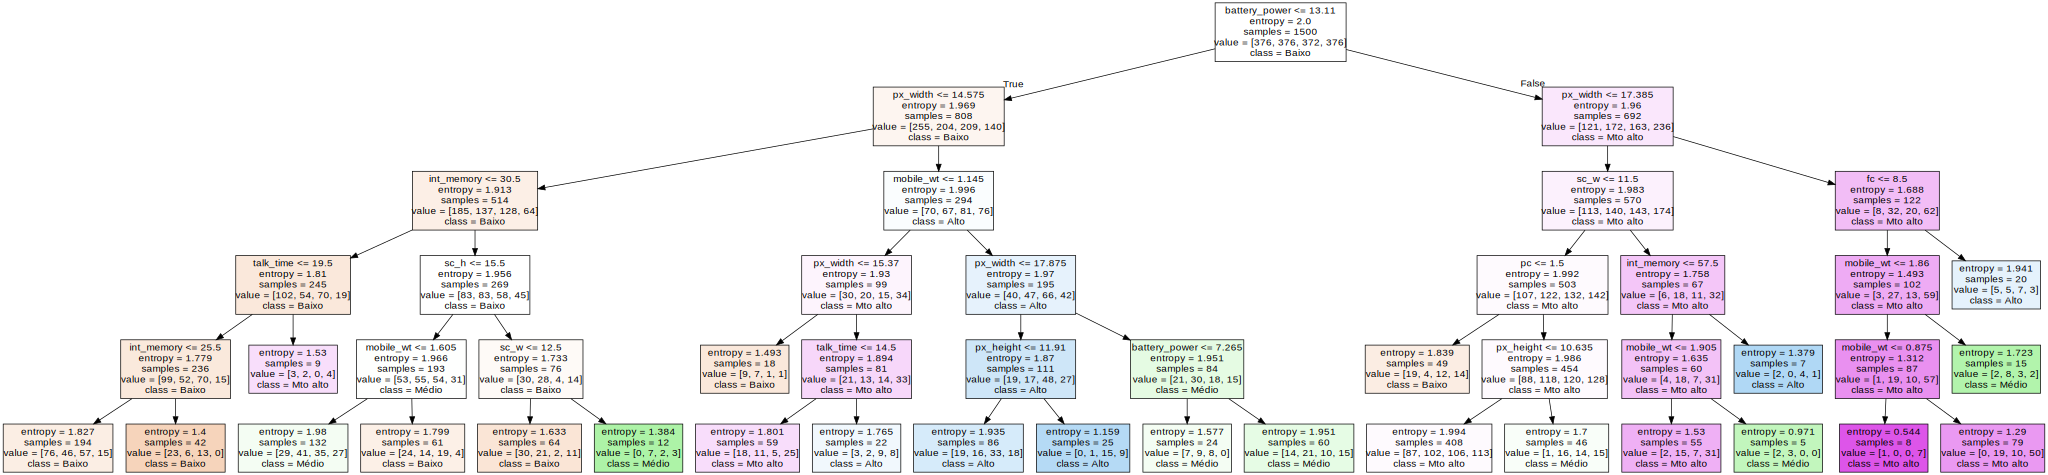

In [406]:
# DOT data
dot_data = tree.export_graphviz(dtree2, out_file=None,
                                feature_names=X_train2.columns,
                                class_names=display_labels,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf")
graph

In [407]:
graph.render("dtree2")

'dtree2.pdf'

Acurácia: 0.304
Precisão: 0.29368309423641414
Recall: 0.3050655241935484
F1-Score: 0.2896009990767281
Matriz de Confusão:


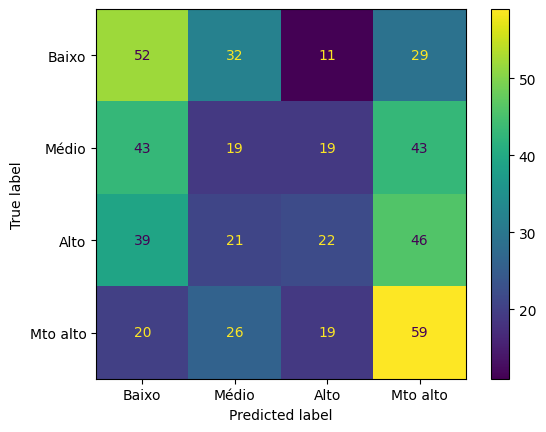

In [408]:
y_preddt1 = dtree2.predict(X_test2)
checkMetrics(y_test2, y_preddt1, display=display_labels)

In [409]:
probpool2.add(dtree2.predict_proba(X_test2))



---


### **LEARNING THE DECISION TREE CLASSIFIER 3**

In [410]:
dtree3 = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=50).fit(X_train3, y_train3)

[Text(0.5244565217391305, 0.9166666666666666, 'battery_power <= 2231.5\nentropy = 2.0\nsamples = 1500\nvalue = [376, 376, 372, 376]\nclass = y[0]'),
 Text(0.25, 0.75, 'battery_power <= 1103.0\nentropy = 1.342\nsamples = 774\nvalue = [376, 329, 69, 0]\nclass = y[0]'),
 Text(0.11956521739130435, 0.5833333333333334, 'battery_power <= 572.5\nentropy = 0.529\nsamples = 342\nvalue = [301, 41, 0, 0]\nclass = y[0]'),
 Text(0.043478260869565216, 0.4166666666666667, 'battery_power <= 382.5\nentropy = 0.121\nsamples = 121\nvalue = [119, 2, 0, 0]\nclass = y[0]'),
 Text(0.021739130434782608, 0.25, 'entropy = 0.0\nsamples = 48\nvalue = [48, 0, 0, 0]\nclass = y[0]'),
 Text(0.06521739130434782, 0.25, 'battery_power <= 389.0\nentropy = 0.181\nsamples = 73\nvalue = [71, 2, 0, 0]\nclass = y[0]'),
 Text(0.043478260869565216, 0.08333333333333333, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0]\nclass = y[1]'),
 Text(0.08695652173913043, 0.08333333333333333, 'entropy = 0.106\nsamples = 72\nvalue = [71, 1,

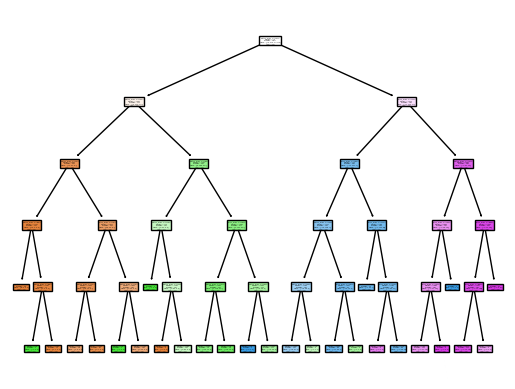

In [411]:
tree.plot_tree(dtree3, feature_names = X.columns, class_names=True,filled = True)

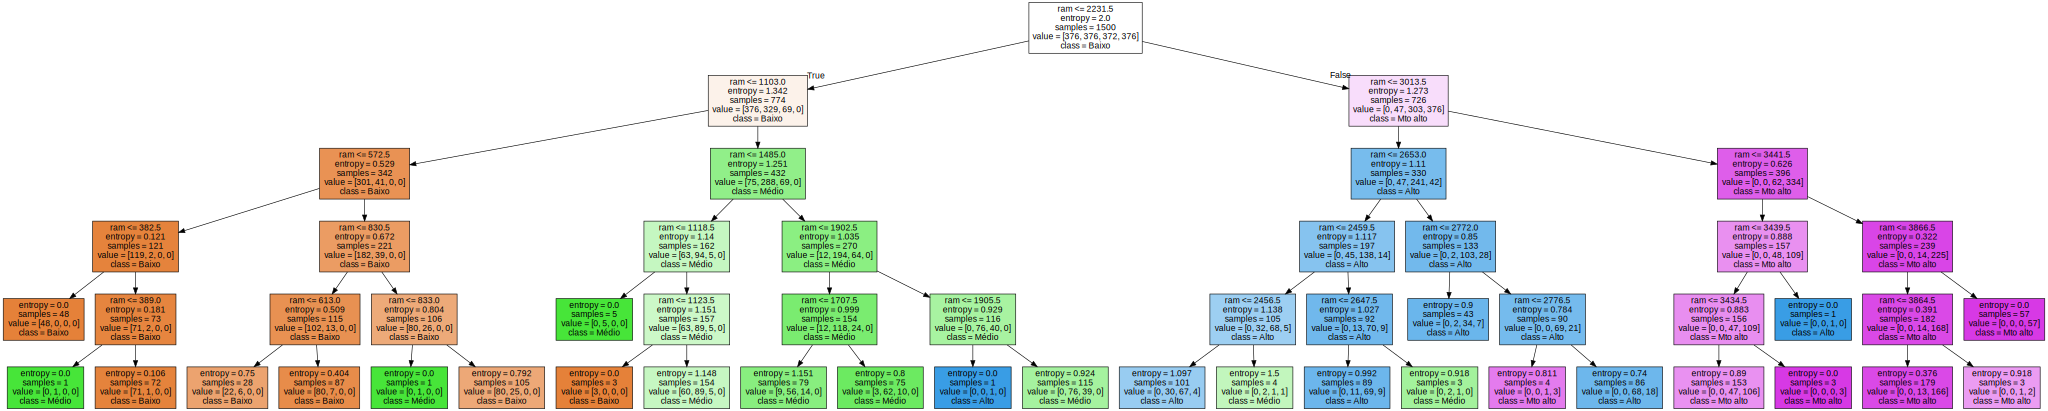

In [412]:
# DOT data
dot_data = tree.export_graphviz(dtree3, out_file=None,
                                feature_names=X_train3.columns,
                                class_names=display_labels,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="pdf")
graph

In [413]:
graph.render("dtree3")

'dtree3.pdf'

Acurácia: 0.714
Precisão: 0.7245430577393064
Recall: 0.715851814516129
F1-Score: 0.7151882187541132
Matriz de Confusão:


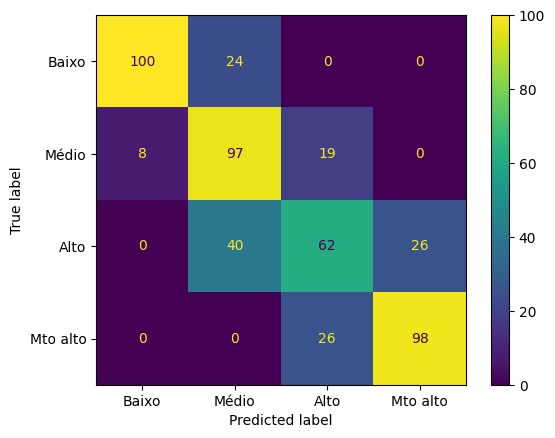

In [414]:
y_preddt = dtree3.predict(X_test3)
checkMetrics(y_test3, y_preddt, display=display_labels)

In [415]:
probpool3.add(dtree3.predict_proba(X_test3))

---
---

## **Random Forests**

###**LEARNING THE RF CLASSIFIER**

In [416]:
rforest = RandomForestClassifier(max_depth=10).fit(X_train, y_train)

Acurácia: 0.856
Precisão: 0.8570862203350248
Recall: 0.8570438508064516
F1-Score: 0.8560444093220481
Matriz de Confusão:


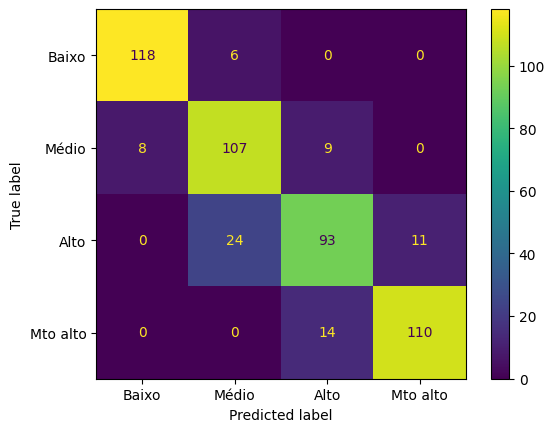

In [417]:
y_predrf = rforest.predict(X_test)
checkMetrics(y_test, y_predrf, display_labels)

In [418]:
probpool.add(rforest.predict_proba(X_test))

---
###**LEARNING THE RF CLASSIFIER 2**

In [419]:
rforest2 = RandomForestClassifier(max_depth=10).fit(X_train2, y_train2)

Acurácia: 0.354
Precisão: 0.3512261788631443
Recall: 0.35490171370967744
F1-Score: 0.34887451342364306
Matriz de Confusão:


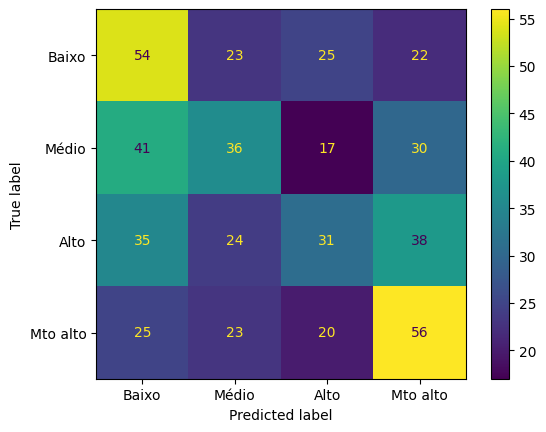

In [420]:
y_predrf = rforest2.predict(X_test2)
checkMetrics(y_test2, y_predrf, display_labels)

In [421]:
probpool2.add(rforest2.predict_proba(X_test2))

---
###**LEARNING THE RF CLASSIFIER 3**

In [422]:
rforest3 = RandomForestClassifier(max_depth=10).fit(X_train3, y_train3)

Acurácia: 0.696
Precisão: 0.7021192251216135
Recall: 0.6975176411290323
F1-Score: 0.6973307670677549
Matriz de Confusão:


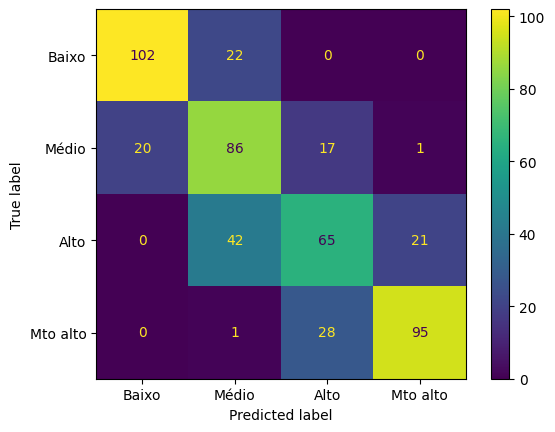

In [423]:
y_predrf = rforest3.predict(X_test3)
checkMetrics(y_test3, y_predrf, display_labels)

In [424]:
probpool3.add(rforest3.predict_proba(X_test3))

---
---
## **KNNs**

### **LEARNING THE KNN CLASSIFIER**

11


<Axes: >

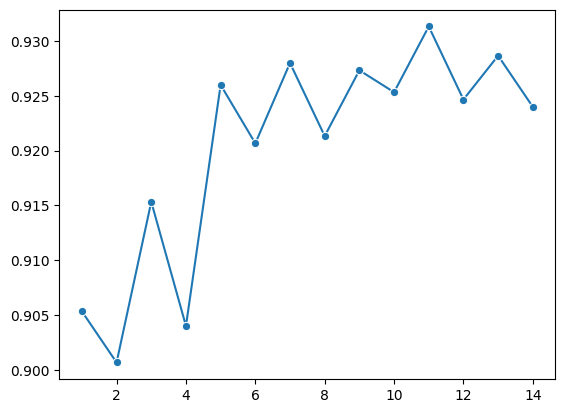

In [425]:
k_values = [i for i in range(1,15)]
scores = []

for k in k_values:
  tknn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(tknn, X_train, y_train, cv=5)
  scores.append(np.mean(score))
  if(scores[-1] >= max(scores)):
    k_best = k

print(k_best)
sns.lineplot(x=k_values,y=scores, marker ='o')

In [426]:
knn = KNeighborsClassifier(n_neighbors=k_best).fit(X_train, y_train)

Acurácia: 0.936
Precisão: 0.9366575634755617
Recall: 0.9361139112903225
F1-Score: 0.9361771264950338
Matriz de Confusão:


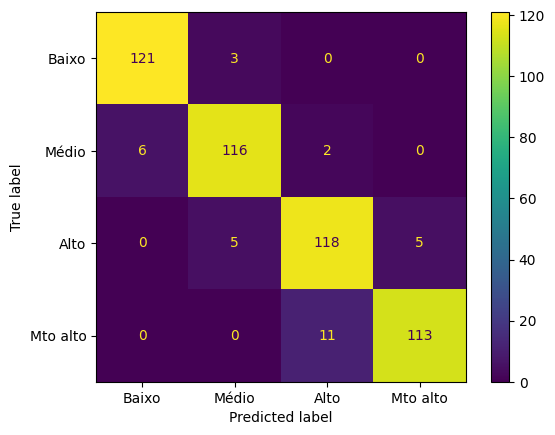

In [427]:
y_predknn = knn.predict(X_test)
checkMetrics(y_test, y_predknn, display_labels)

In [428]:
probpool.add(knn.predict_proba(X_test))

---

### **LEARNING THE KNN CLASSIFIER 2**

14


<Axes: >

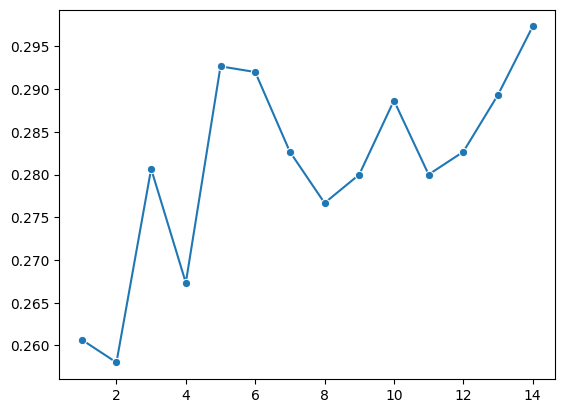

In [429]:
k_values = [i for i in range(1,15)]
scores = []

for k in k_values:
  tknn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(tknn, X_train2, y_train2, cv=5)
  scores.append(np.mean(score))
  if(scores[-1] >= max(scores)):
    k_best = k

print(k_best)
sns.lineplot(x=k_values,y=scores, marker ='o')

In [430]:
knn2 = KNeighborsClassifier(n_neighbors=k_best).fit(X_train2, y_train2)

Acurácia: 0.284
Precisão: 0.28358713658766516
Recall: 0.2848412298387097
F1-Score: 0.27991803407568605
Matriz de Confusão:


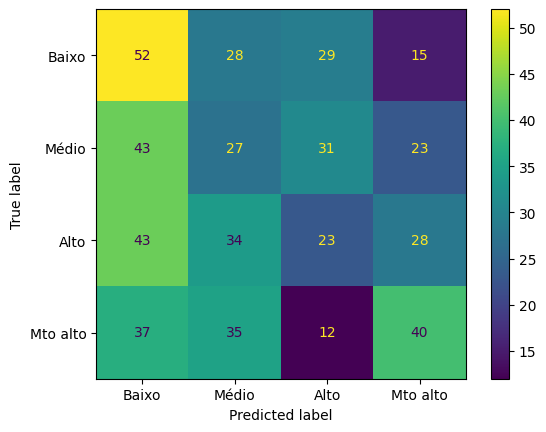

In [431]:
y_predknn = knn2.predict(X_test2)
checkMetrics(y_test2, y_predknn, display_labels)

In [432]:
probpool2.add(knn2.predict_proba(X_test2))

---

### **LEARNING THE KNN CLASSIFIER 3**

12


<Axes: >

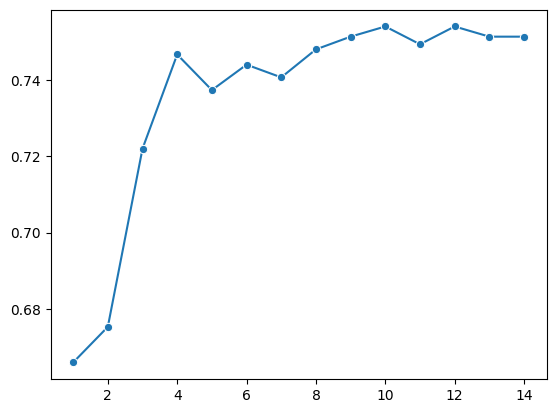

In [433]:
k_values = [i for i in range(1,15)]
scores = []

for k in k_values:
  tknn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(tknn, X_train3, y_train3, cv=5)
  scores.append(np.mean(score))
  if(scores[-1] >= max(scores)):
    k_best = k

print(k_best)
sns.lineplot(x=k_values,y=scores, marker ='o')

In [434]:
knn3 = KNeighborsClassifier(n_neighbors=k_best).fit(X_train3, y_train3)

Acurácia: 0.714
Precisão: 0.7115942028985507
Recall: 0.7156628024193548
F1-Score: 0.7109941032799831
Matriz de Confusão:


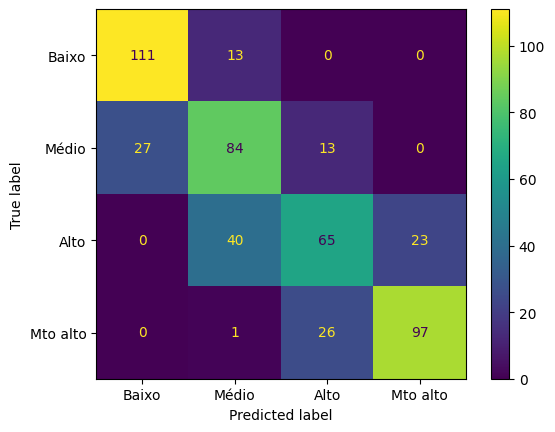

In [435]:
y_predknn = knn3.predict(X_test3)
checkMetrics(y_test3, y_predknn, display_labels)

In [436]:
probpool3.add(knn3.predict_proba(X_test3))

---
---
## **MLPs**

---
###**LEARNING THE MLP CLASSIFIER**

In [437]:
seed = randint(0, 4294967295)
#seed = 4262000293
mlp = MLPClassifier(learning_rate_init=0.05, alpha=0.5, random_state=seed, early_stopping=True, max_iter=1000).fit(X_ntrain, y_ntrain)
#mlp = MLPClassifier(solver='lbfgs', random_state=seed, max_fun=30000).fit(X_train, y_train)

<Axes: >

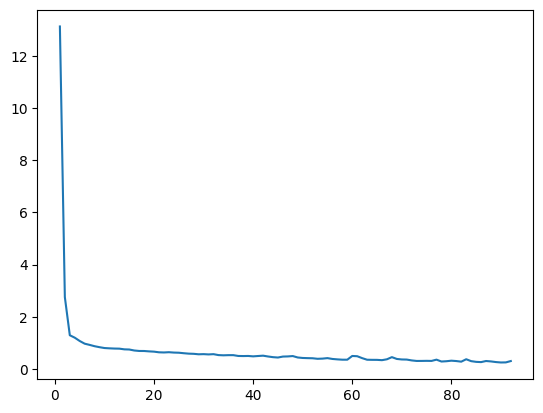

In [438]:
sns.lineplot(y=mlp.loss_curve_, x=range(1, mlp.n_iter_ + 1))

Acurácia: 0.914
Precisão: 0.9151728625407014
Recall: 0.9145035282258065
F1-Score: 0.9144266006797976
Matriz de Confusão:


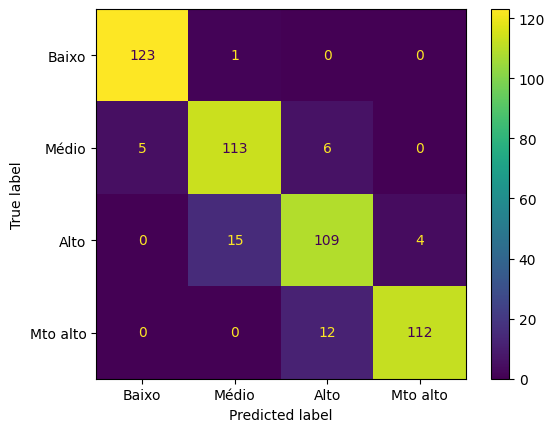

No layers: 3


MLPClassifier(alpha=0.5, early_stopping=True, learning_rate_init=0.05,
              max_iter=1000, random_state=2913751797)

In [439]:
y_predmlp = mlp.predict(X_ntest)
checkMetrics(y_ntest, y_predmlp, display_labels)
print("No layers:", mlp.n_layers_)
mlp

In [440]:
probpool.add(mlp.predict_proba(X_ntest))

---
###**LEARNING THE MLP CLASSIFIER 2**

In [441]:
seed = randint(0, 4294967295)
#seed = 4262000293
mlp2 = MLPClassifier(learning_rate_init=0.005, alpha=0.5, random_state=seed, early_stopping=True, max_iter=1000).fit(X_ntrain2, y_ntrain2)
#mlp = MLPClassifier(solver='lbfgs', random_state=seed, max_fun=30000).fit(X_train, y_train)

<Axes: >

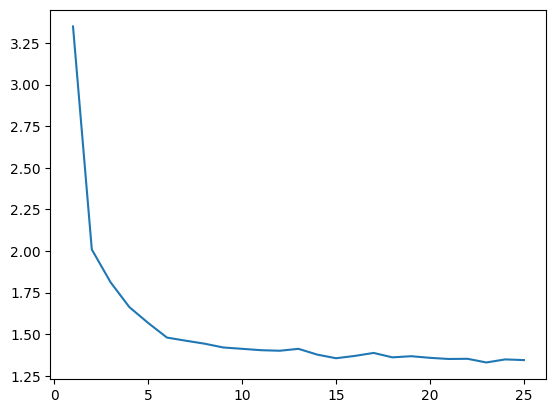

In [442]:
sns.lineplot(y=mlp2.loss_curve_, x=range(1, mlp2.n_iter_ + 1))

Acurácia: 0.306
Precisão: 0.2953375594632972
Recall: 0.3071446572580645
F1-Score: 0.2822726062899028
Matriz de Confusão:


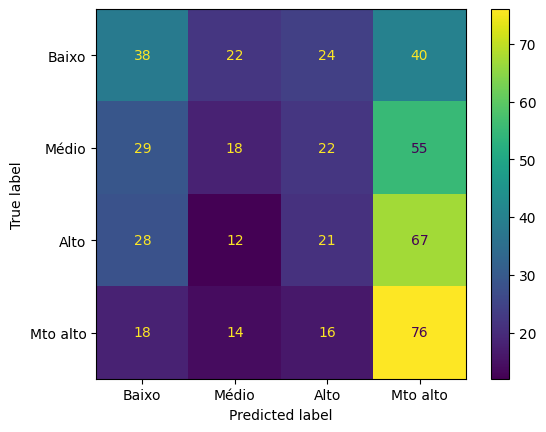

No layers: 3


MLPClassifier(alpha=0.5, early_stopping=True, learning_rate_init=0.005,
              max_iter=1000, random_state=3957161196)

In [443]:
y_predmlp = mlp2.predict(X_ntest2)
checkMetrics(y_ntest2, y_predmlp, display_labels)
print("No layers:", mlp2.n_layers_)
mlp2

In [444]:
probpool2.add(mlp2.predict_proba(X_ntest2))

---
###**LEARNING THE MLP CLASSIFIER 3**

In [445]:
#seed = randint(0, 4294967295)
seed = 297205148 # (melhor caso)
mlp3 = MLPClassifier(hidden_layer_sizes=(3,4), learning_rate_init=0.01, alpha=0.05, random_state=seed, max_iter=2000).fit(X_train3, y_train3)
#mlp = MLPClassifier(solver='lbfgs', random_state=seed, max_fun=30000).fit(X_train, y_train)

<Axes: >

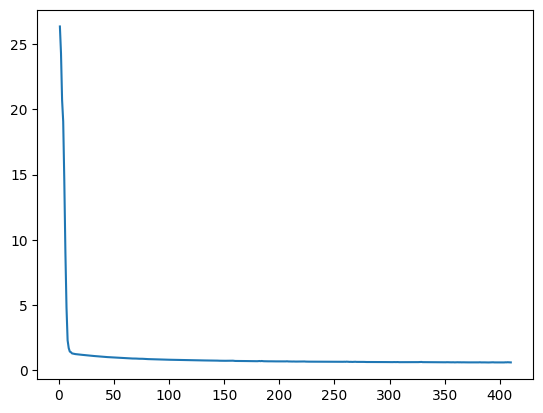

In [446]:
sns.lineplot(y=mlp3.loss_curve_, x=range(1, mlp3.n_iter_ + 1))

Acurácia: 0.72
Precisão: 0.7211875378100424
Recall: 0.7215221774193549
F1-Score: 0.7194235058884302
Matriz de Confusão:


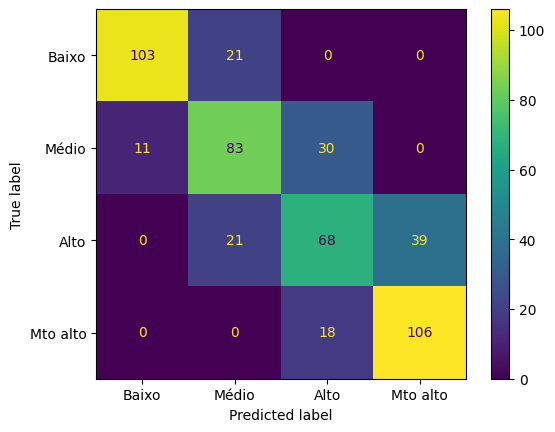

No layers: 4


MLPClassifier(alpha=0.05, hidden_layer_sizes=(3, 4), learning_rate_init=0.01,
              max_iter=2000, random_state=297205148)

In [447]:
y_predmlp = mlp3.predict(X_test3)
checkMetrics(y_test3, y_predmlp, display_labels)
print("No layers:", mlp3.n_layers_)
mlp3

Apesar de aqui ter sido usado o melhor caso, isso foi por pura sorte do estado inicial (e de seus outros hiperparâmetros); normalmente ele não consegue aprender direito e acaba chutando toda vez em uma única classe

In [448]:
probpool3.add(mlp3.predict_proba(X_test3))

---
---
# PFIs + PDPs

Todos os PFIs foram plotados foram nessa ordem: o 1o é de um modelo treinado com dataset original e o 2o é de um modelo treinado com o dataset com features escaladas. Todos os modelos (menos os MLPs) foram treinados com os mesmos hiperparâmetros para ser feita uma análise da diferença entre esses modelos.

In [449]:
xtrains = (X_train, X_train2, X_train3)
xtrains_norm = (X_ntrain, X_ntrain2, X_train3)

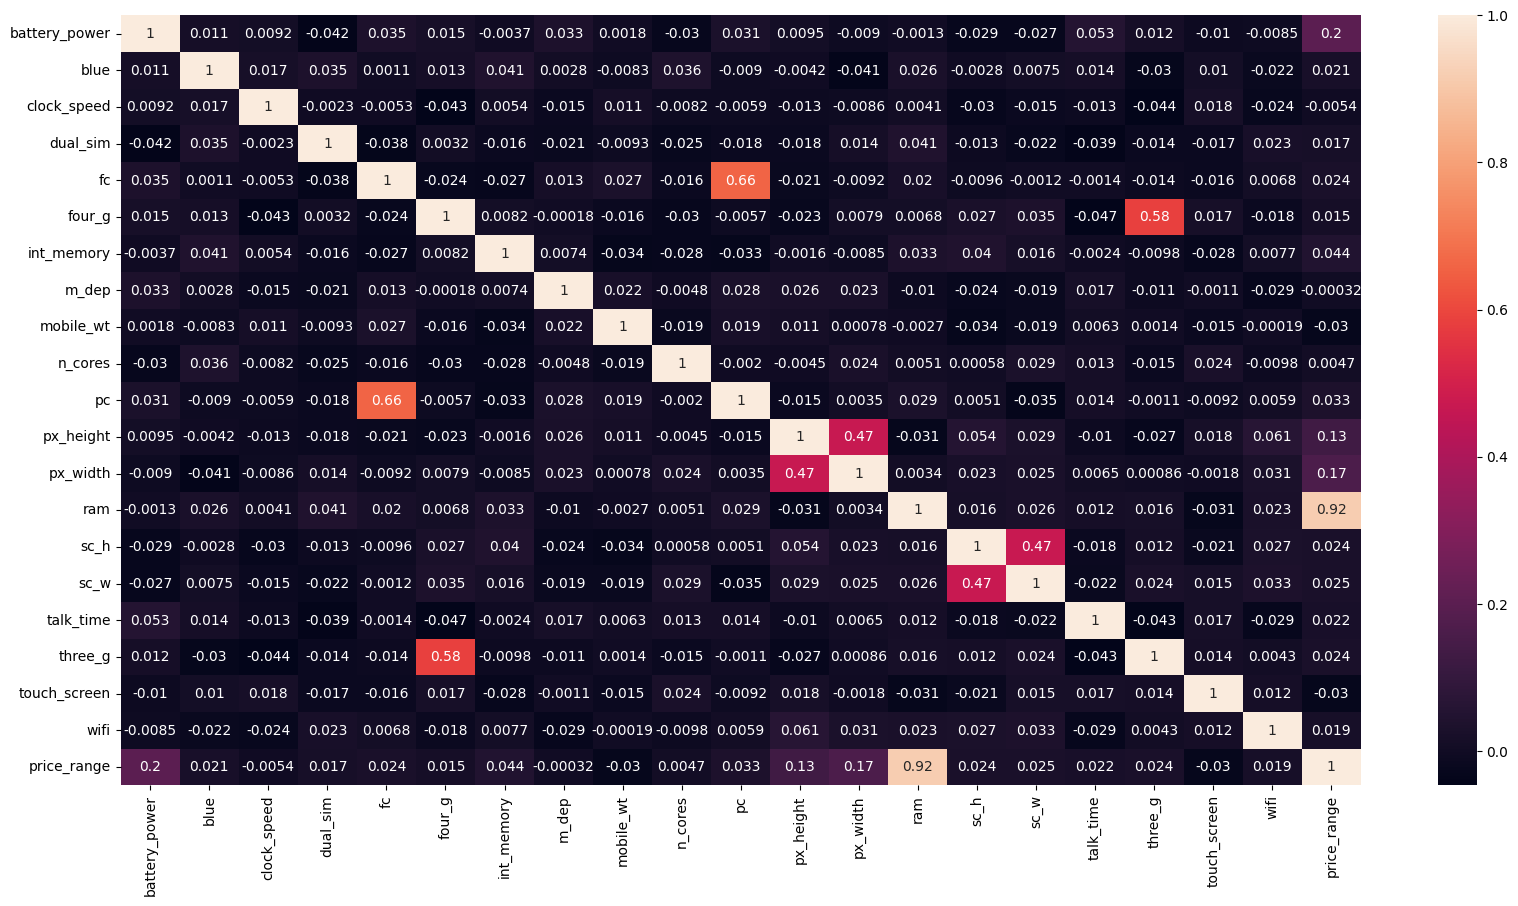

In [450]:
plt.figure(figsize=(20,10))
hm = sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

---
### dtree

In [451]:
dtrees = (dtree, dtree2, dtree3)

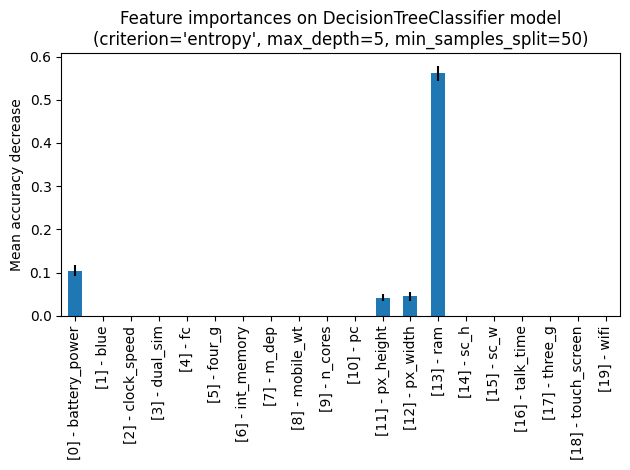

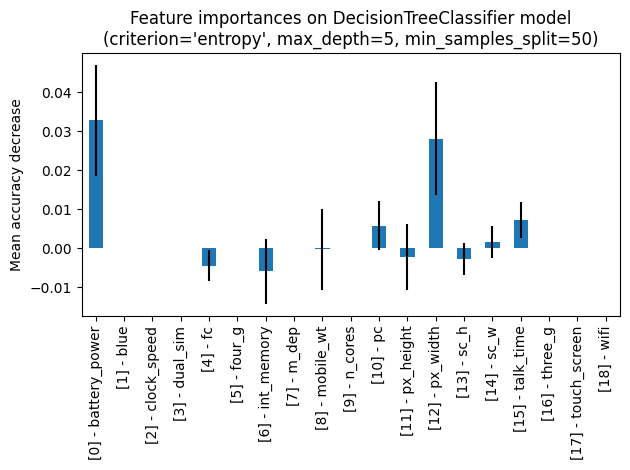

In [452]:
pfi(dtree, X_test, y_test)
pfi(dtree2, X_test2, y_test2)
#pfi(dtree3, X_test3, y_test3) [só possui a coluna 'ram']

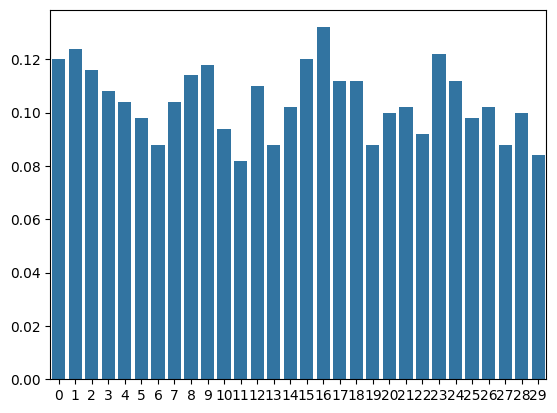

<Axes: >

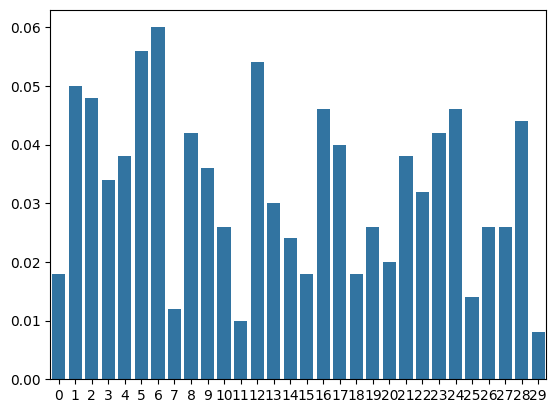

In [453]:
result = permutation_importance(dtree, X_test, y_test,n_repeats=30, random_state=0)
result2 = permutation_importance(dtree2, X_test2, y_test2,n_repeats=30, random_state=0)
sns.barplot(result.importances[0])
plt.show()
sns.barplot(result2.importances[0])

O maior desvio padrão seria indicativo de baixa confiança nos resultados?


DecisionTreeClassifier 1:


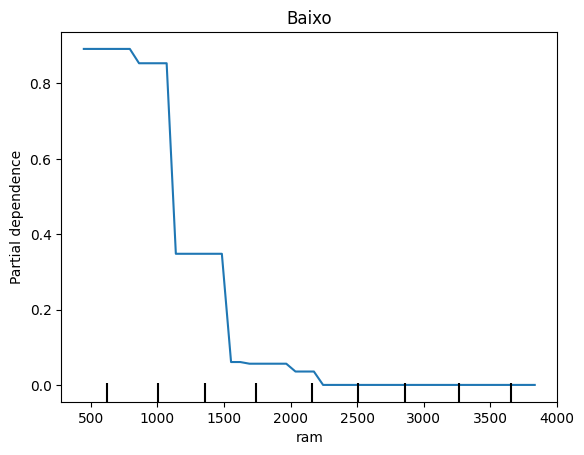


DecisionTreeClassifier 2:


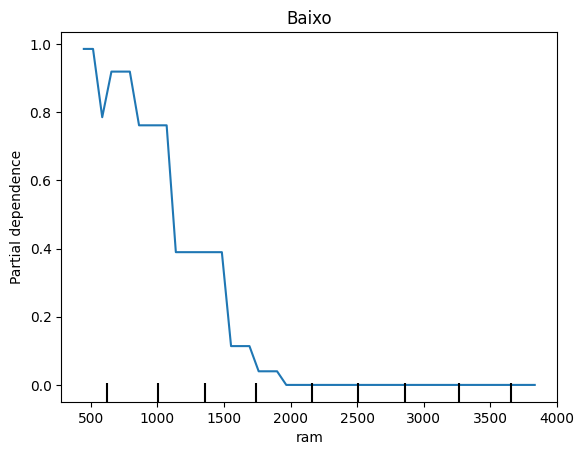


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


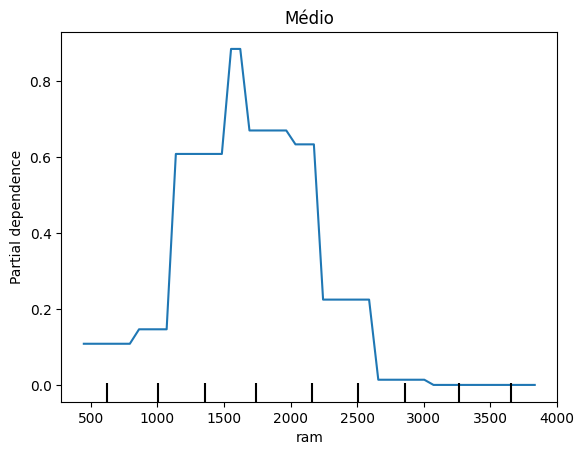


DecisionTreeClassifier 2:


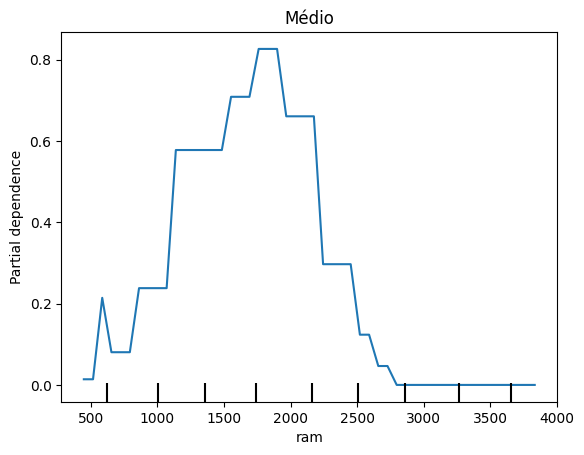


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


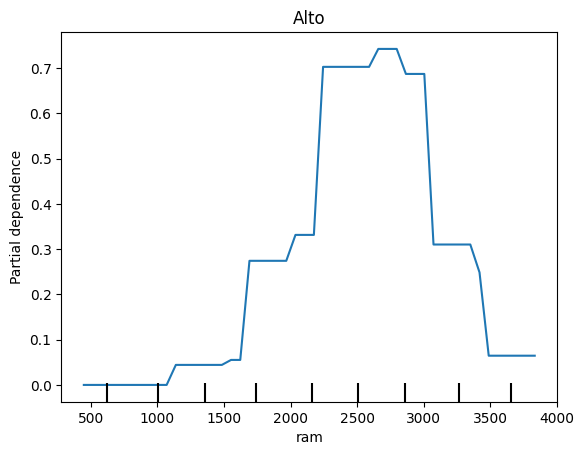


DecisionTreeClassifier 2:


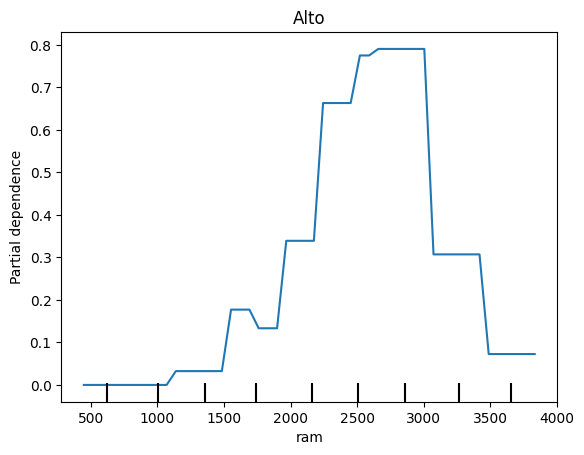


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


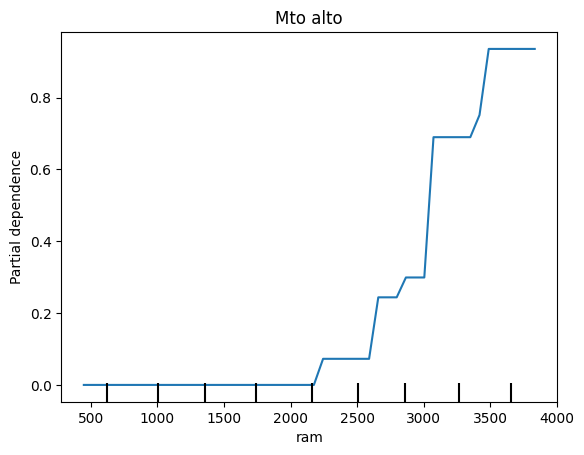


DecisionTreeClassifier 2:


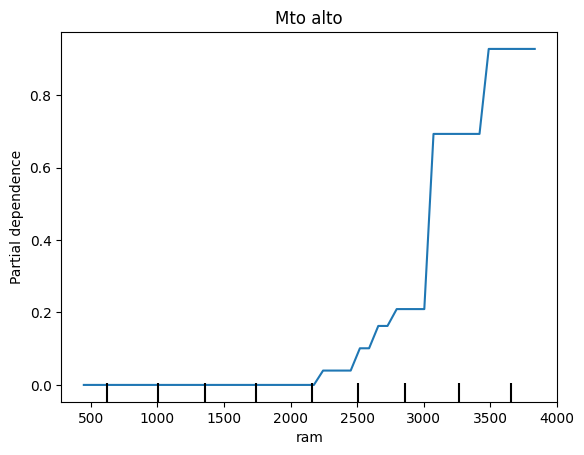


------------------------------------------------------------
------------------------------------------------------------


In [454]:
# Comparação da importância de 'ram'
pdp2versions((dtree, dtree3), (X_train, X_train3), [13], 50)


DecisionTreeClassifier 1:


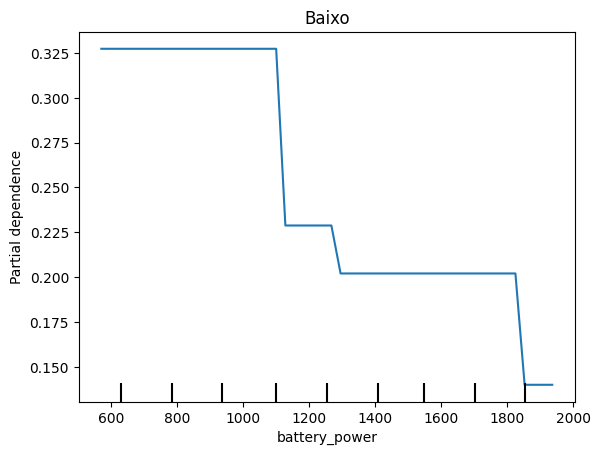


DecisionTreeClassifier 2:


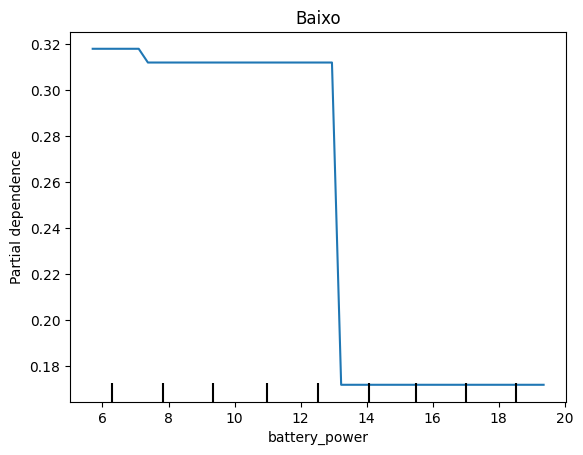


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


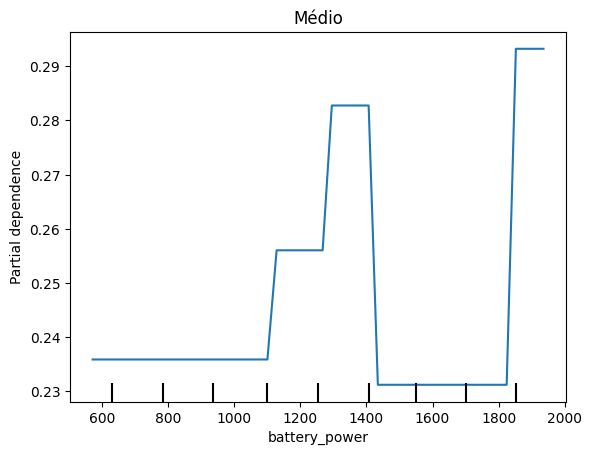


DecisionTreeClassifier 2:


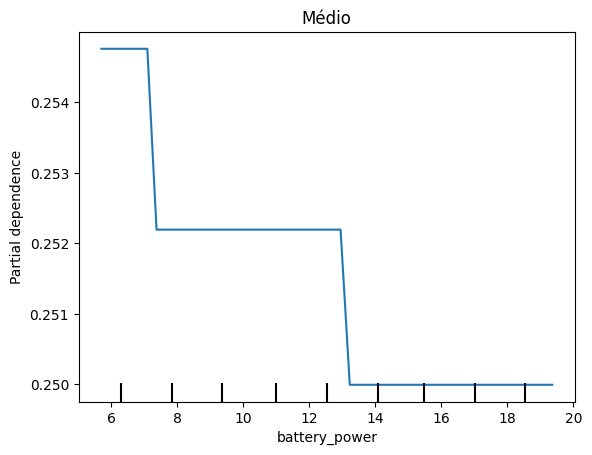


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


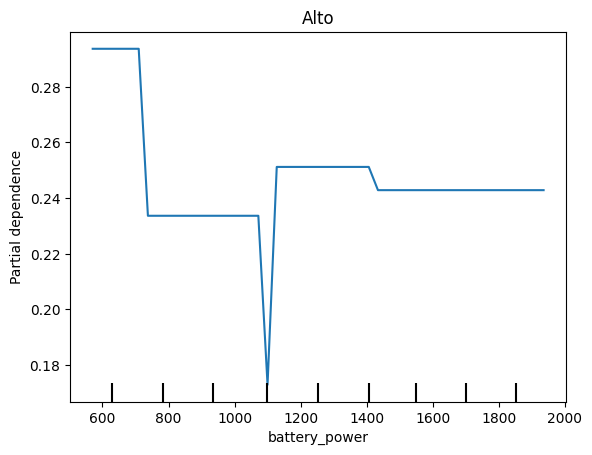


DecisionTreeClassifier 2:


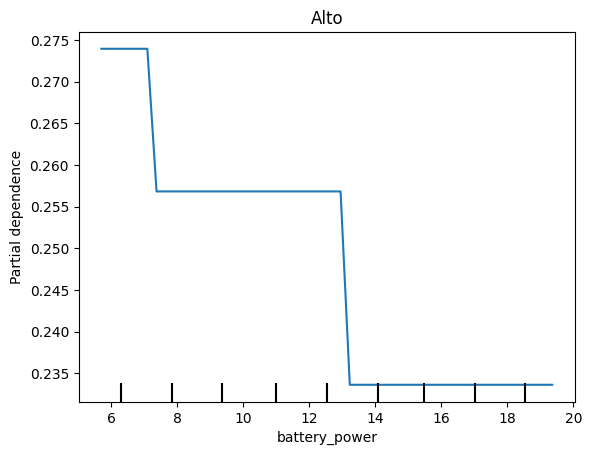


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


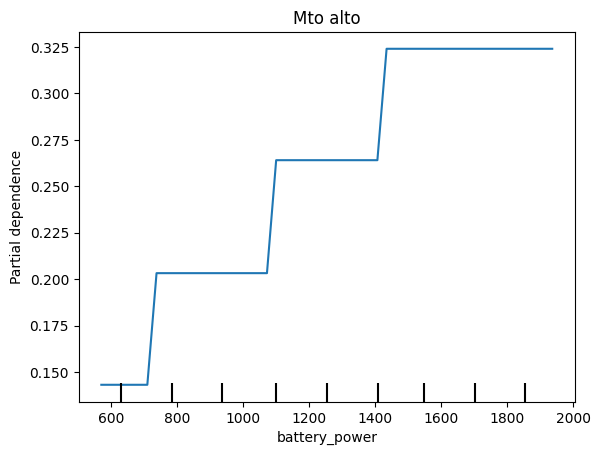


DecisionTreeClassifier 2:


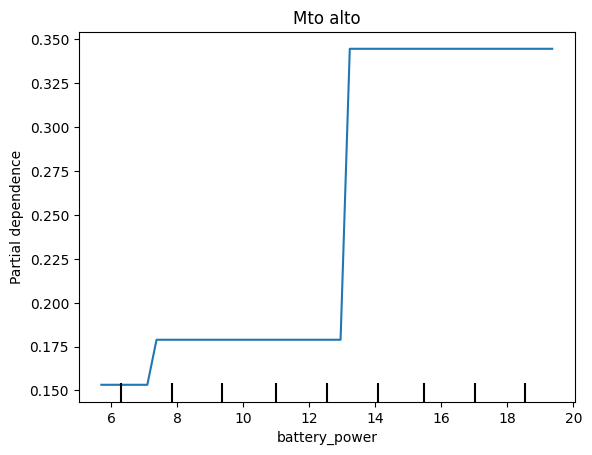


------------------------------------------------------------
------------------------------------------------------------


In [455]:
# comparação da coluna 'pc'
pdp2versions((dtree, dtree2), (X_train, X_train2), [0], 50)


DecisionTreeClassifier 1:


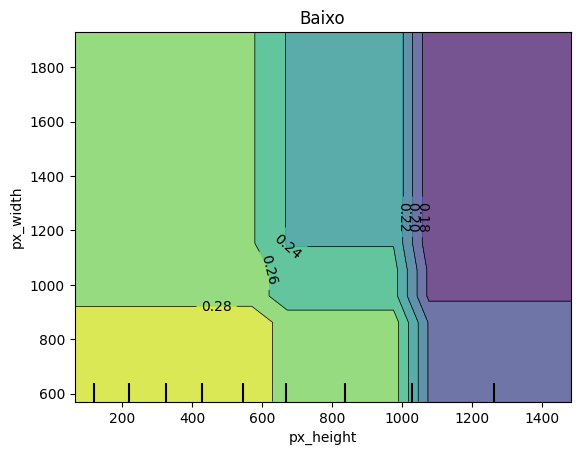


DecisionTreeClassifier 2:


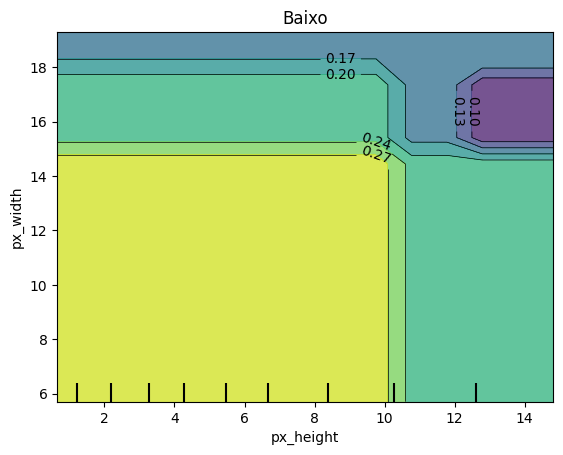


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


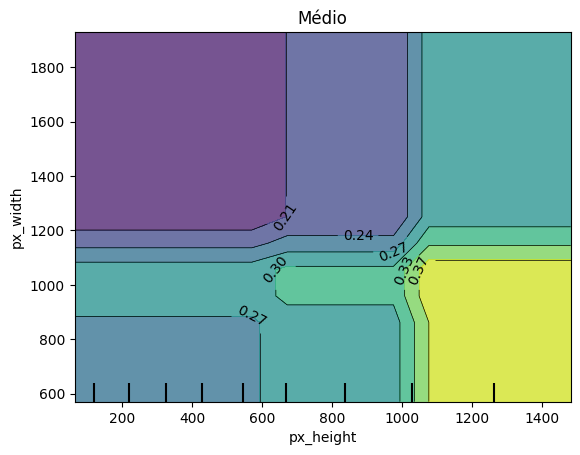


DecisionTreeClassifier 2:


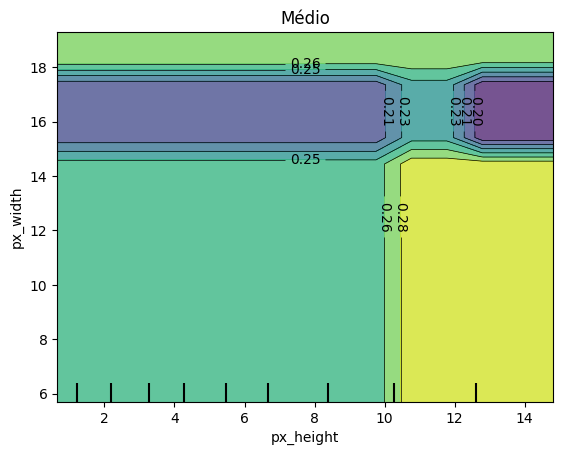


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


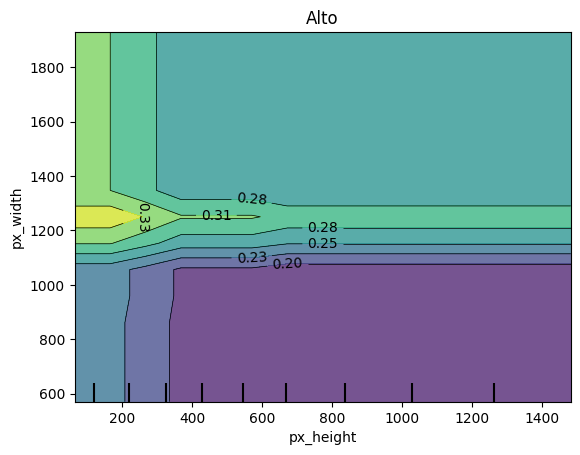


DecisionTreeClassifier 2:


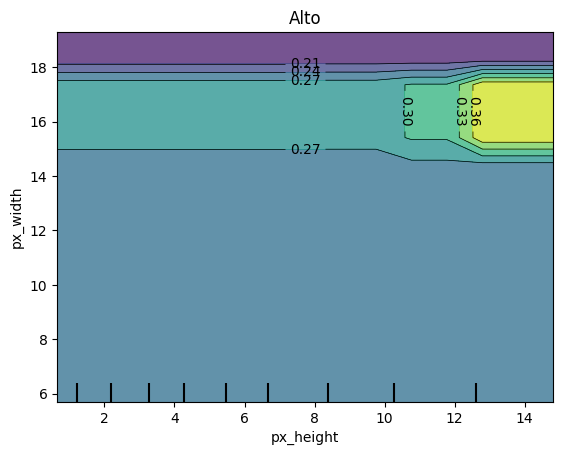


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


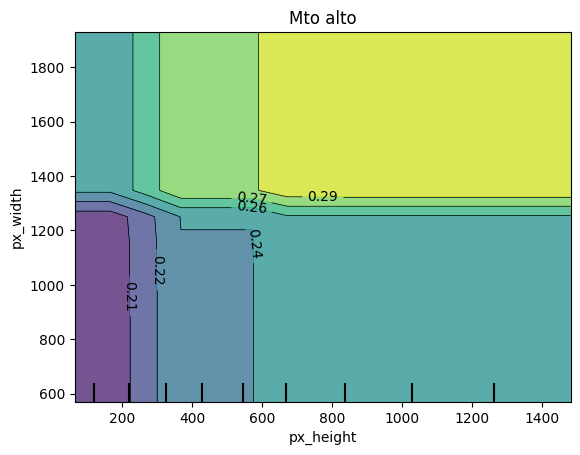


DecisionTreeClassifier 2:


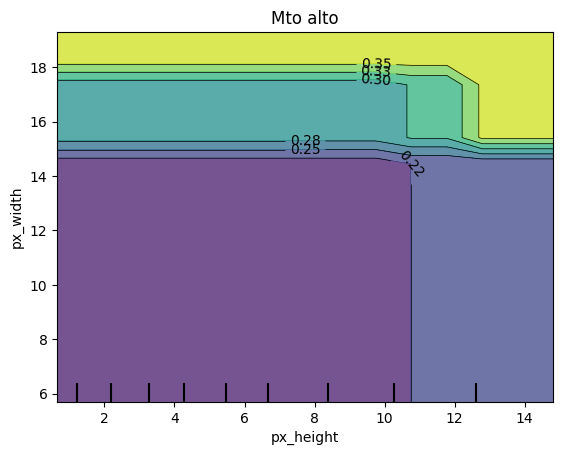


------------------------------------------------------------
------------------------------------------------------------


In [456]:
# px_height, px_width
pdp2versions((dtree, dtree2), (X_train, X_train2), [(11,12)], 15)

---
### rforest

In [457]:
rforests = (rforest, rforest2, rforest3)

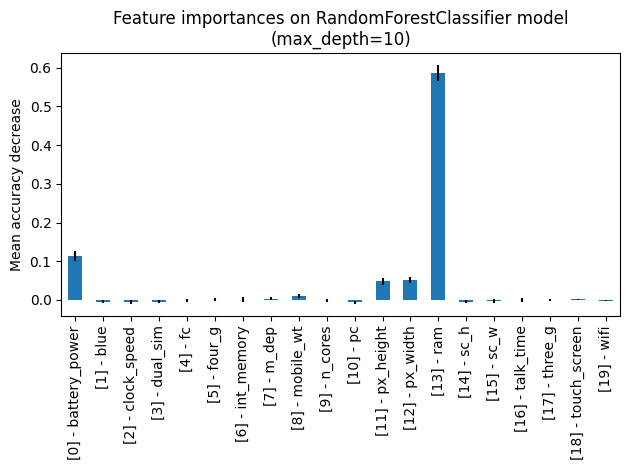

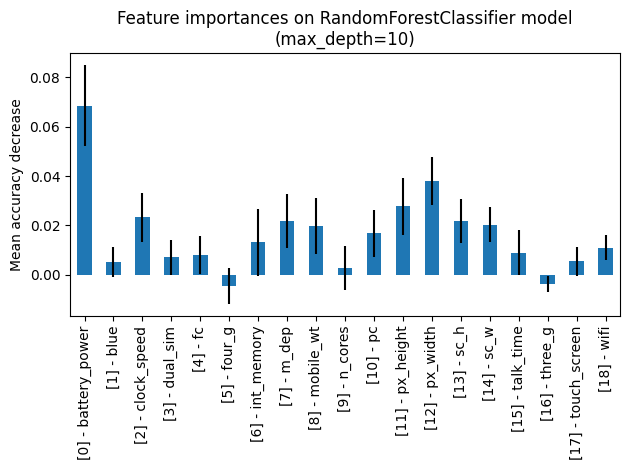

In [458]:
pfi(rforest, X_test, y_test)
pfi(rforest2, X_test2, y_test2)
#pfi(rforest3, X_test2, y_test2) [só possui a coluna 'ram']


RandomForestClassifier 1:


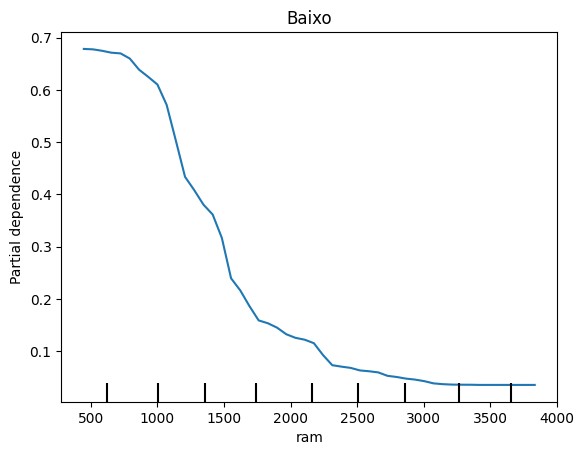


RandomForestClassifier 2:


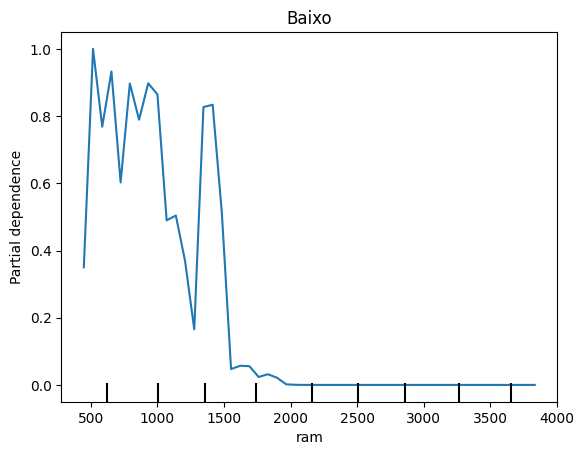


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


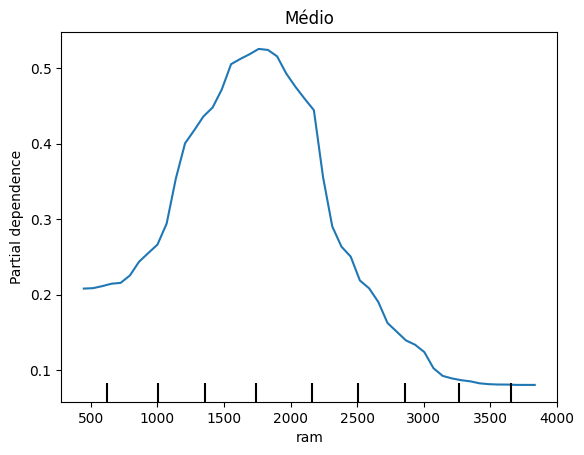


RandomForestClassifier 2:


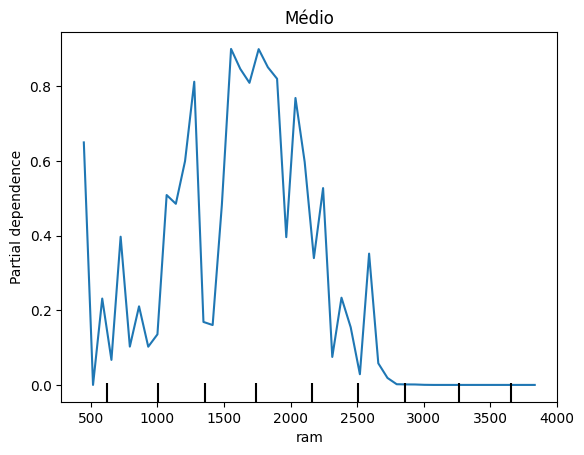


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


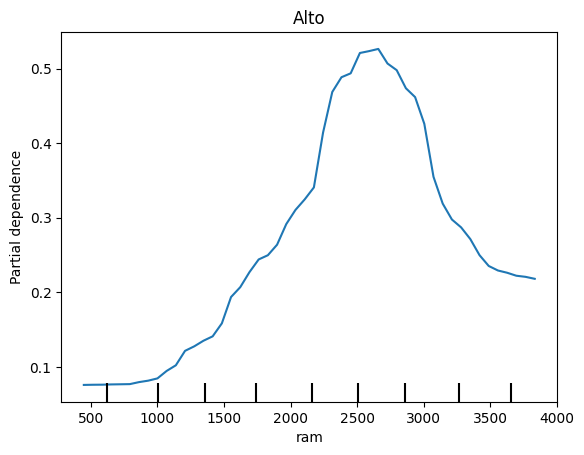


RandomForestClassifier 2:


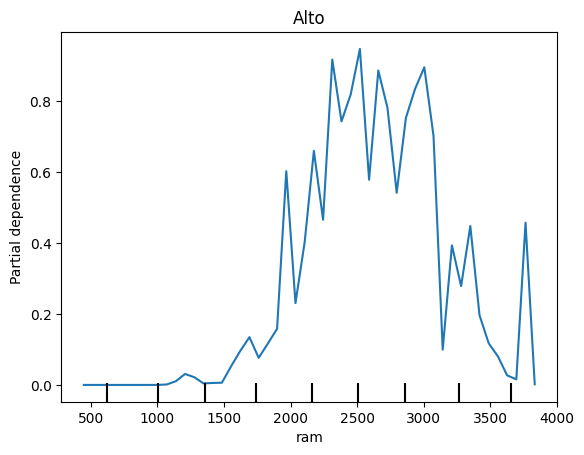


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


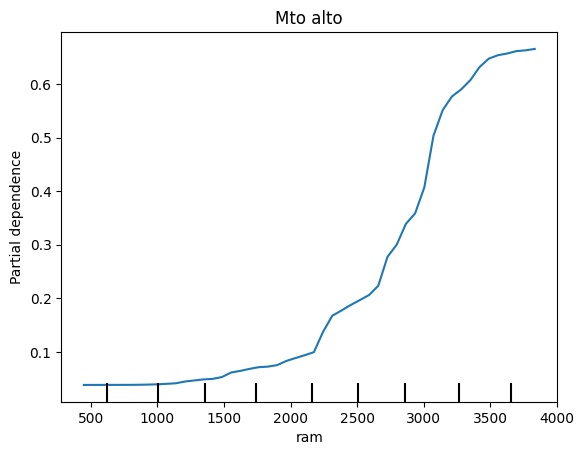


RandomForestClassifier 2:


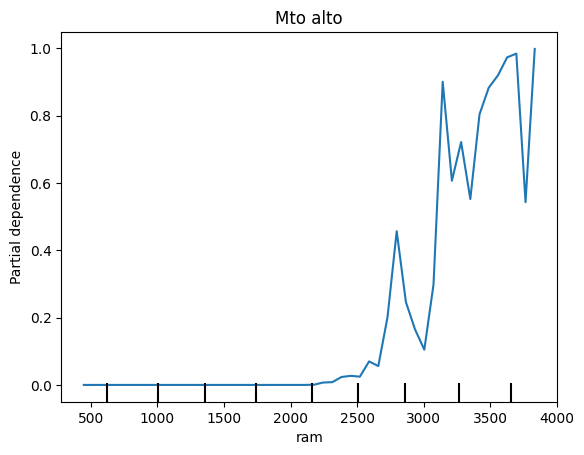


------------------------------------------------------------
------------------------------------------------------------


In [459]:
# Comparação da importância de 'ram'
pdp2versions((rforest, rforest3), (X_train, X_train3), [13], 50)


RandomForestClassifier 1:


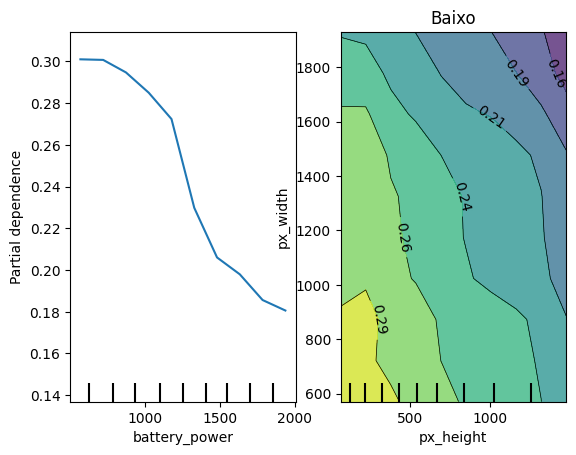


RandomForestClassifier 2:


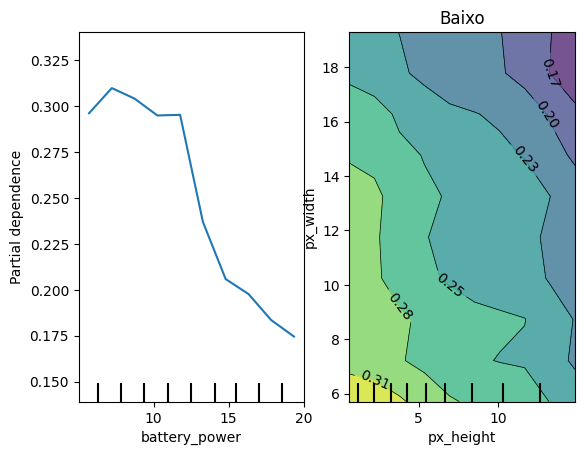


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


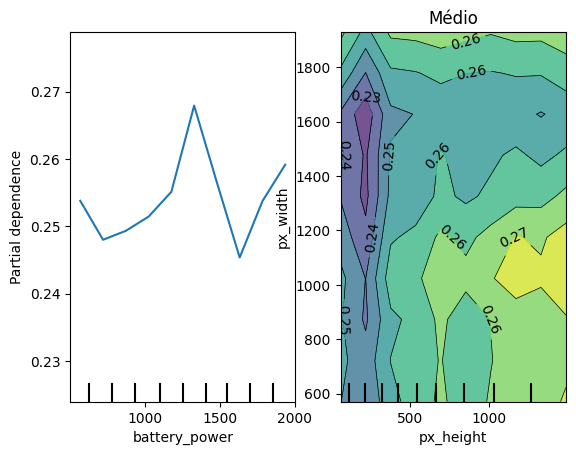


RandomForestClassifier 2:


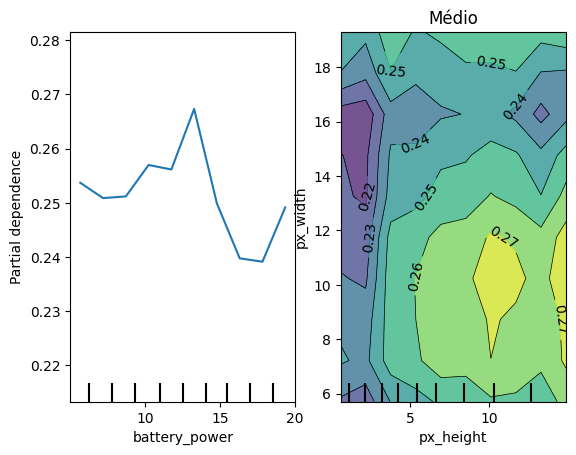


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


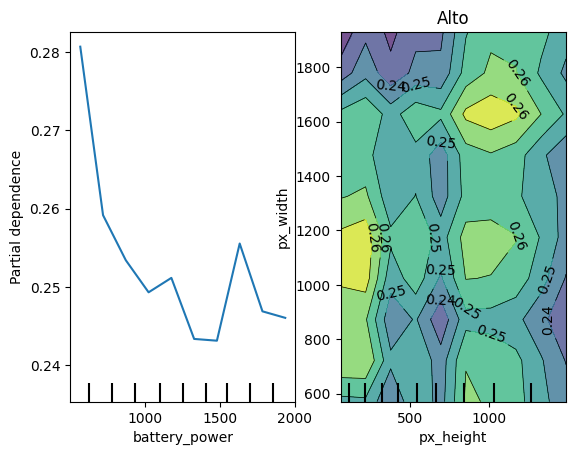


RandomForestClassifier 2:


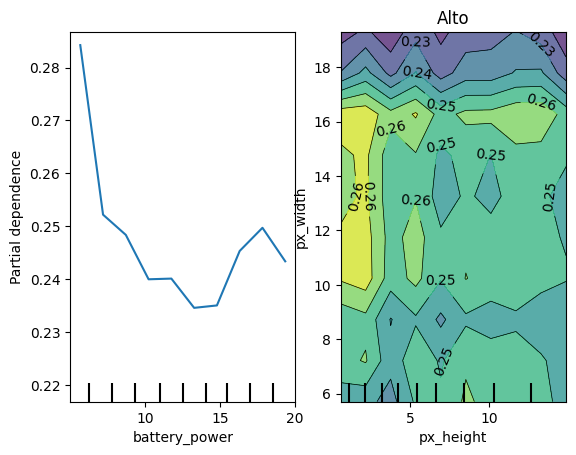


------------------------------------------------------------
------------------------------------------------------------

RandomForestClassifier 1:


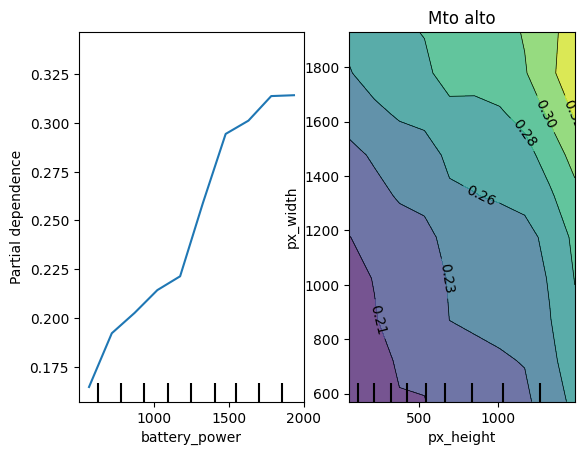


RandomForestClassifier 2:


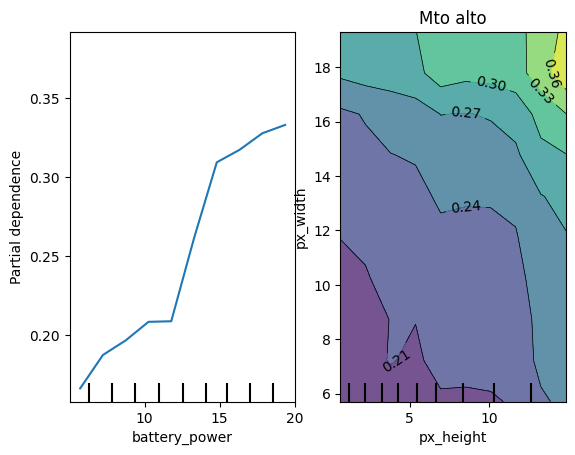


------------------------------------------------------------
------------------------------------------------------------


In [460]:
pdp2versions((rforest, rforest2), (X_train, X_train2), [0, (11, 12)])

---
### knn

In [461]:
knns = (knn, knn2, knn3)

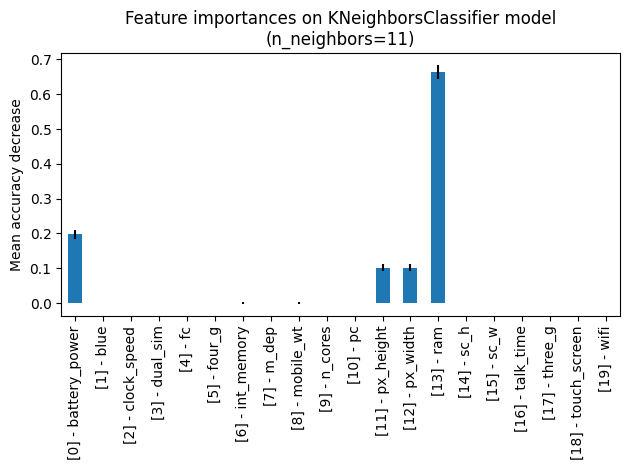

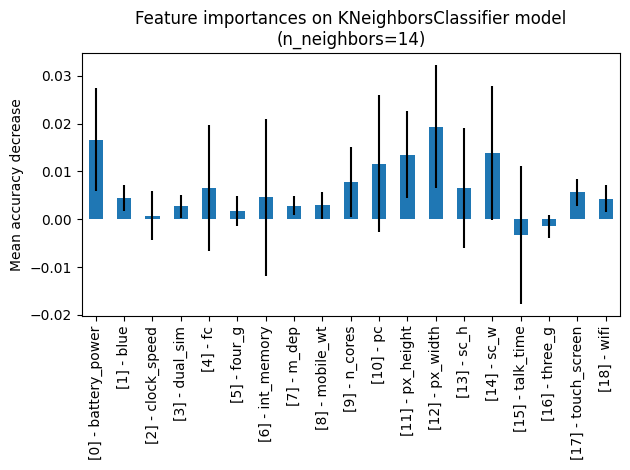

In [462]:
pfi(knn, X_test, y_test)
pfi(knn2, X_test2, y_test2)
#pfi(knn3, X_test2, y_test2) [só possui a coluna 'ram']


KNeighborsClassifier 1:


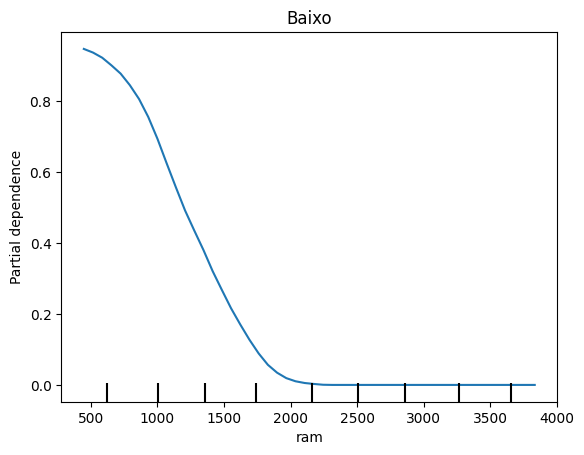


KNeighborsClassifier 2:


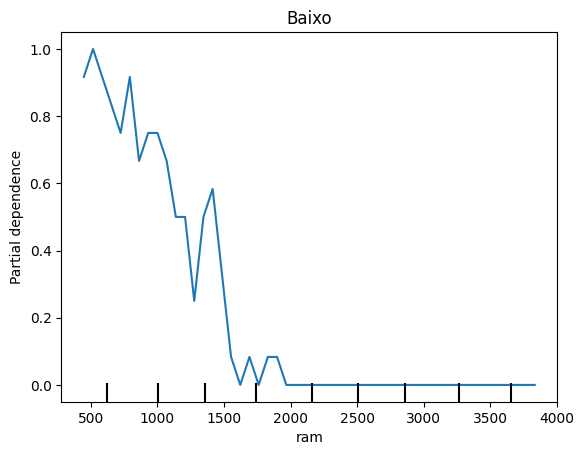


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


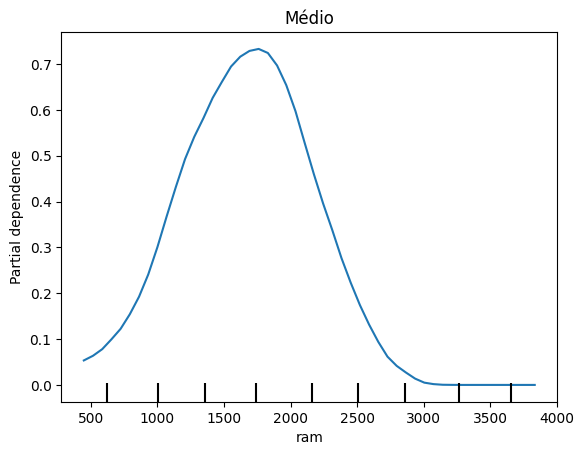


KNeighborsClassifier 2:


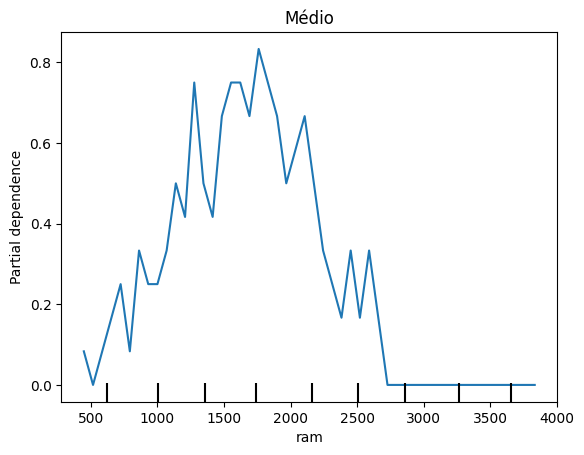


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


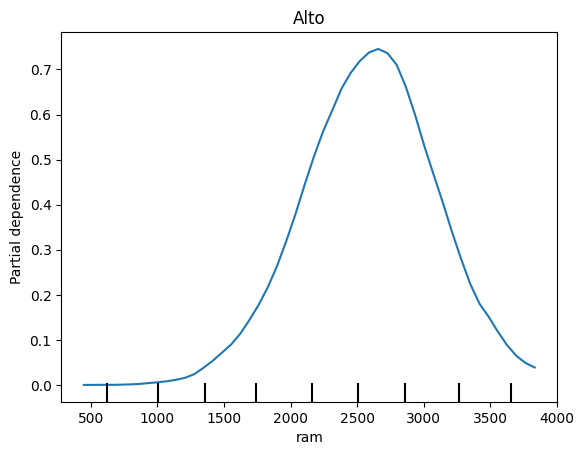


KNeighborsClassifier 2:


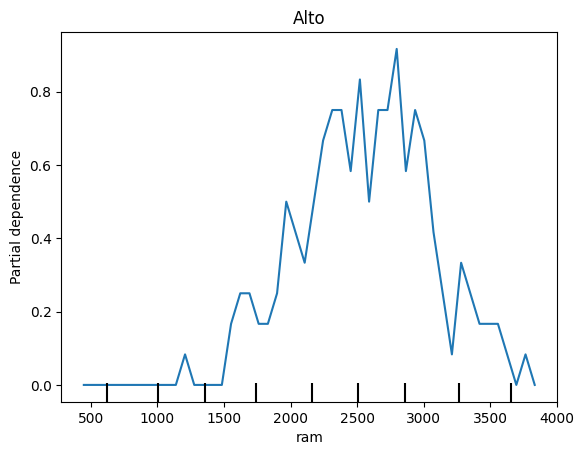


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


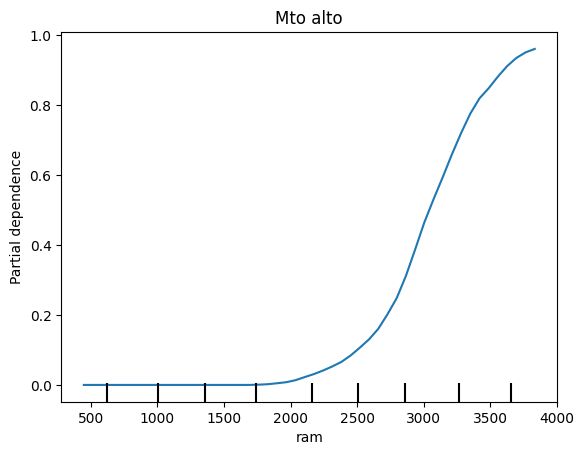


KNeighborsClassifier 2:


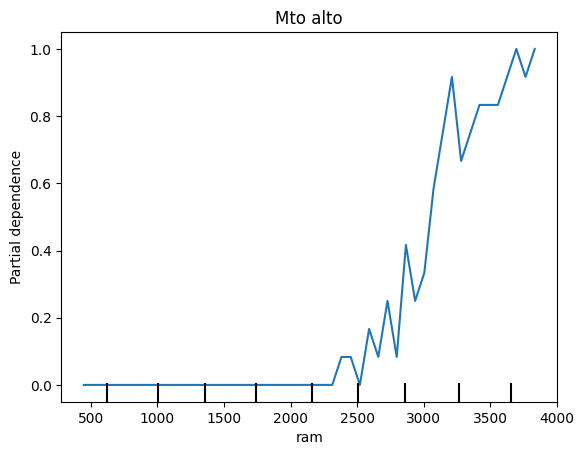


------------------------------------------------------------
------------------------------------------------------------


In [463]:
# Comparação da importância de 'ram'
pdp2versions((knn, knn3), (X_train, X_train3), [13], 50)


KNeighborsClassifier 1:


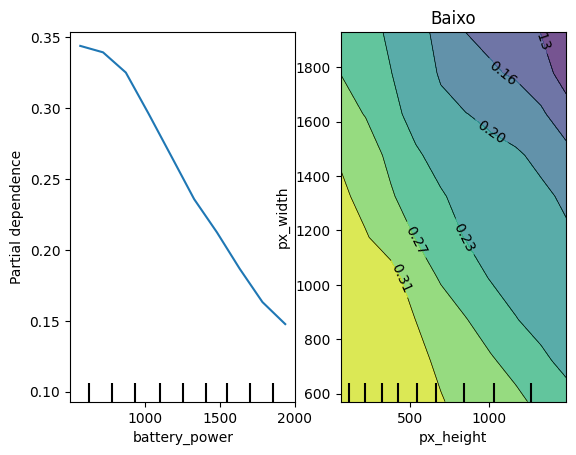


KNeighborsClassifier 2:


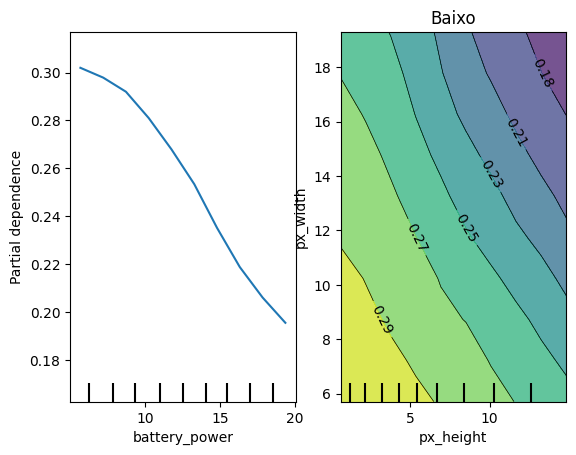


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


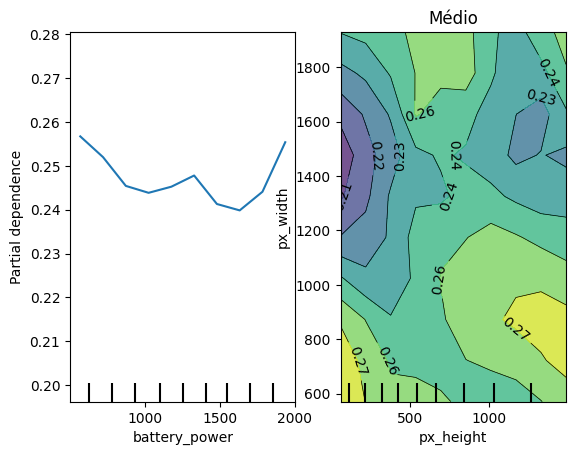


KNeighborsClassifier 2:


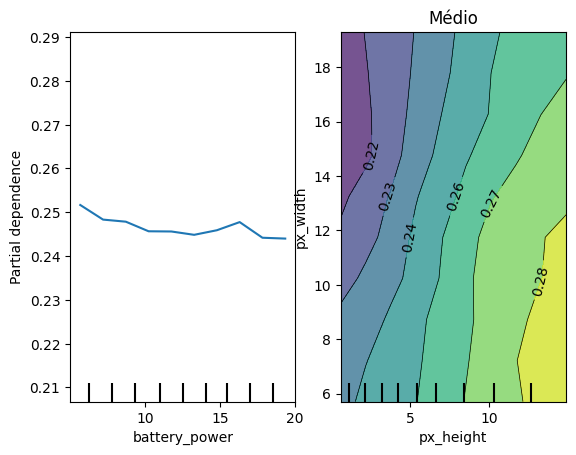


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


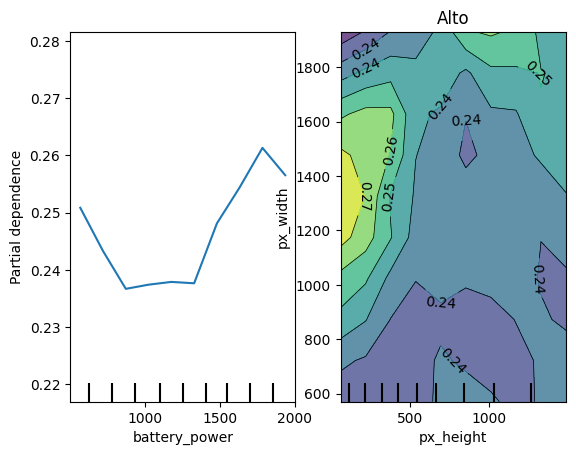


KNeighborsClassifier 2:


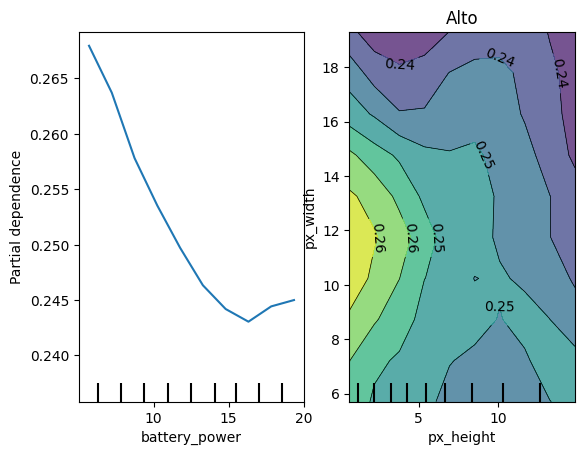


------------------------------------------------------------
------------------------------------------------------------

KNeighborsClassifier 1:


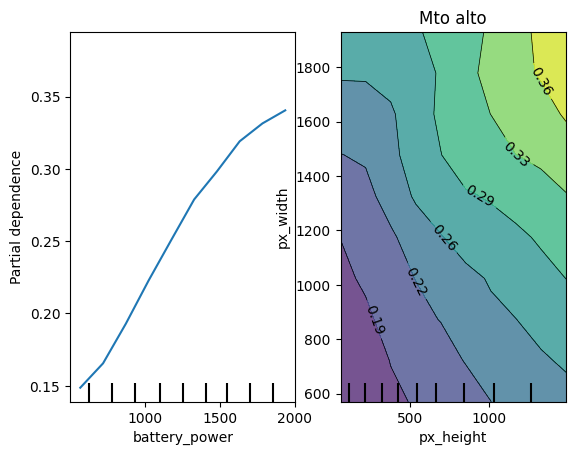


KNeighborsClassifier 2:


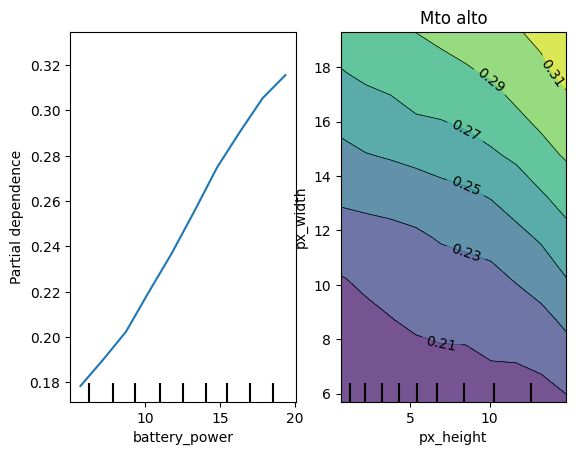


------------------------------------------------------------
------------------------------------------------------------


In [464]:
pdp2versions((knn, knn2), (X_train, X_train2), [0, (11, 12)])

---
###mlp

In [465]:
mlps = (mlp, mlp2, mlp3)

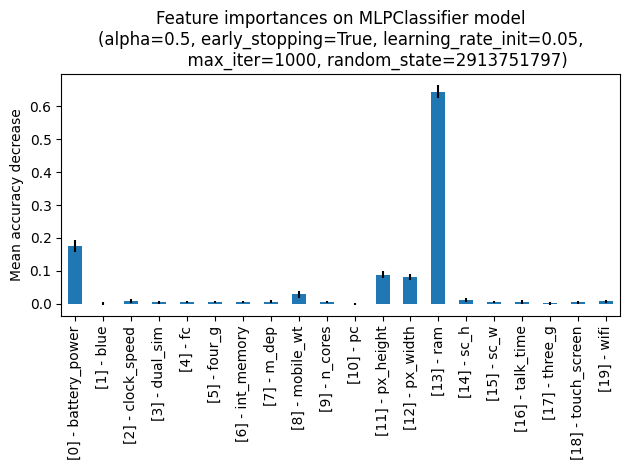

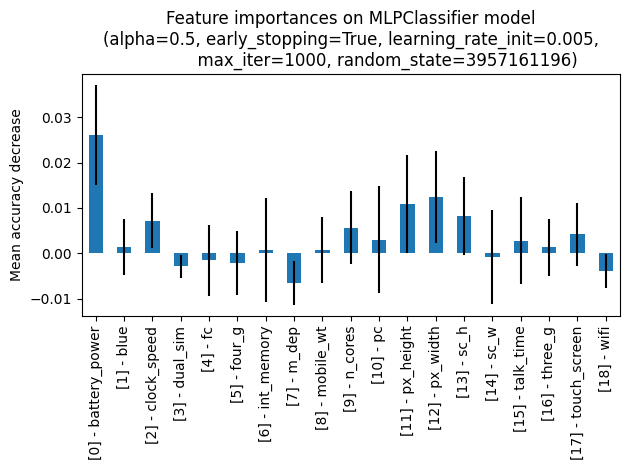

In [466]:
pfi(mlp, X_ntest, y_ntest)
pfi(mlp2, X_ntest2, y_ntest2)
#pfi(mlp3, X_test2, y_test2) [só possui a coluna 'ram']


MLPClassifier 1:


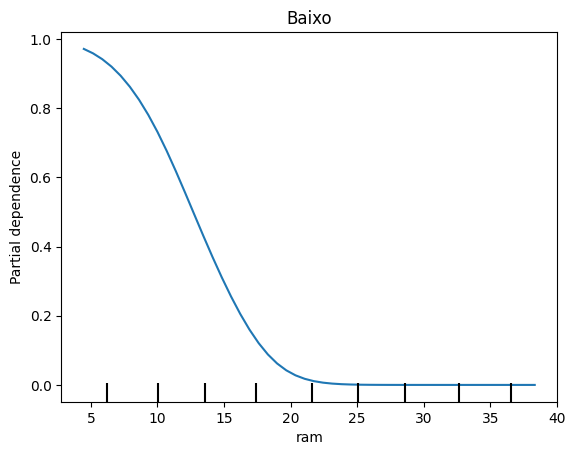


MLPClassifier 2:


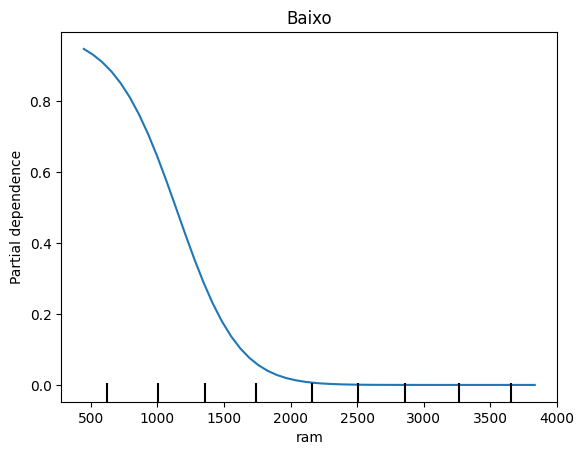


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


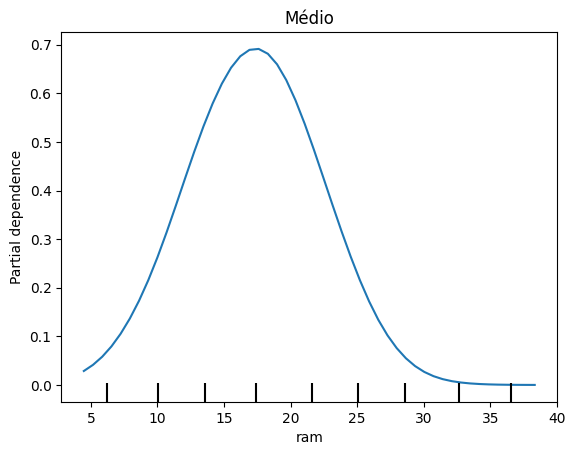


MLPClassifier 2:


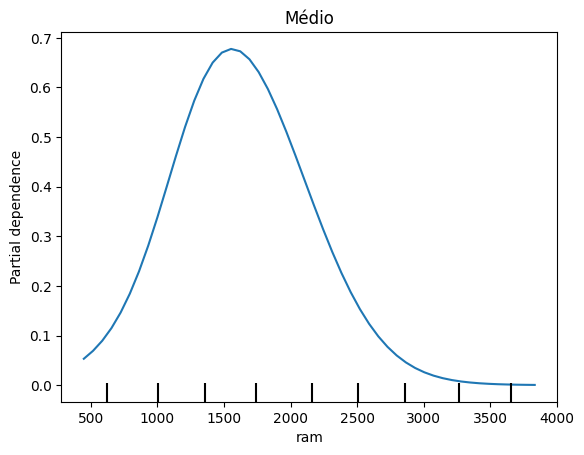


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


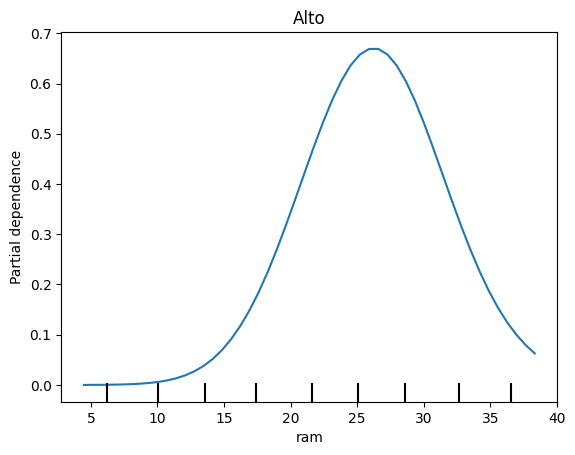


MLPClassifier 2:


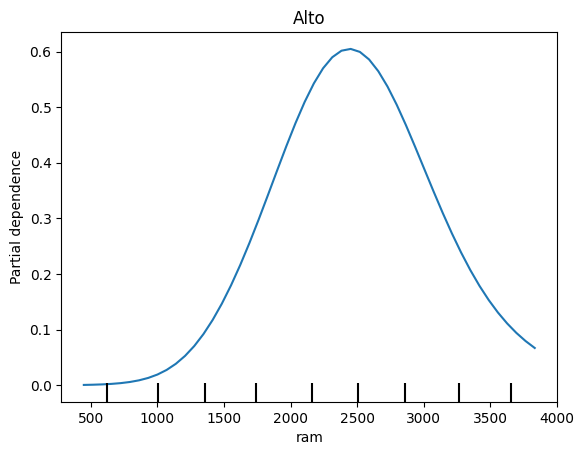


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


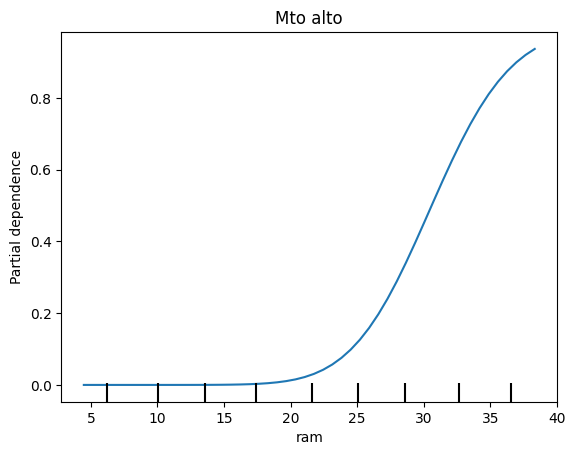


MLPClassifier 2:


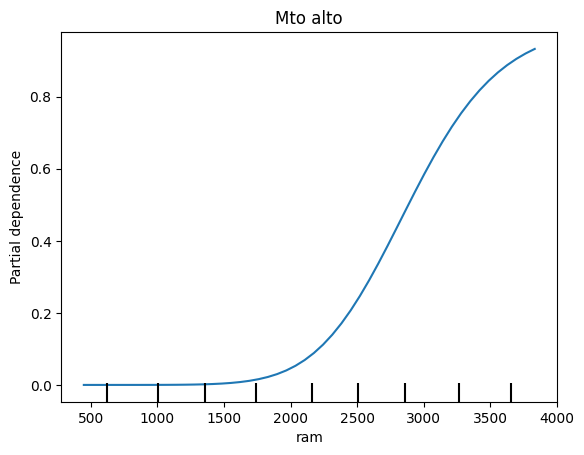


------------------------------------------------------------
------------------------------------------------------------


In [467]:
# Comparação da importância de 'ram'
pdp2versions((mlp, mlp3), (X_ntrain, X_train3), [13], 50)


MLPClassifier 1:


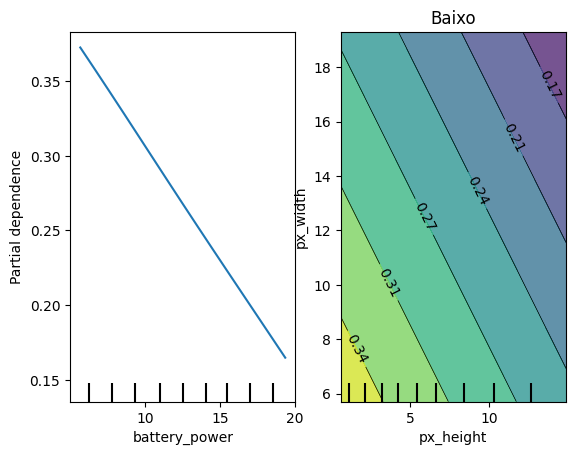


MLPClassifier 2:


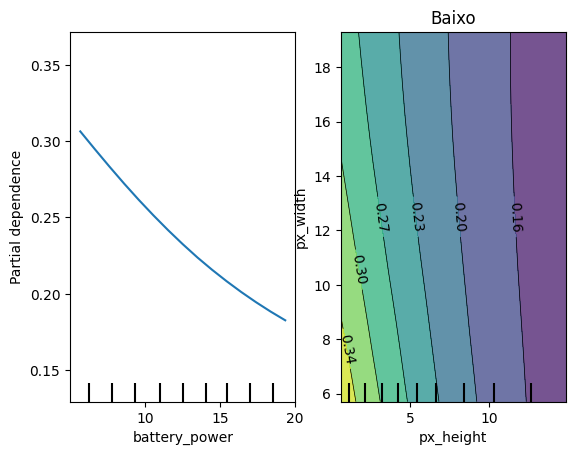


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


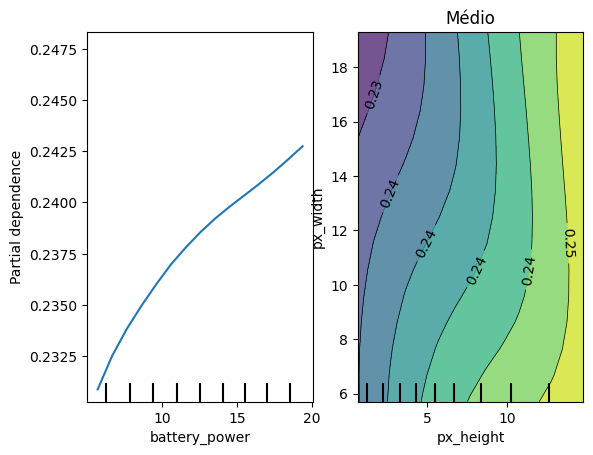


MLPClassifier 2:


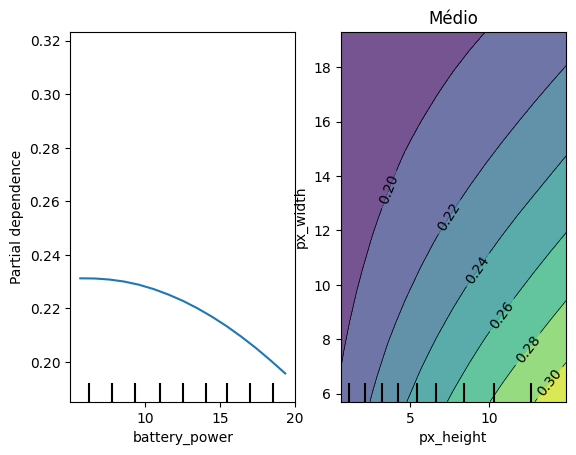


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


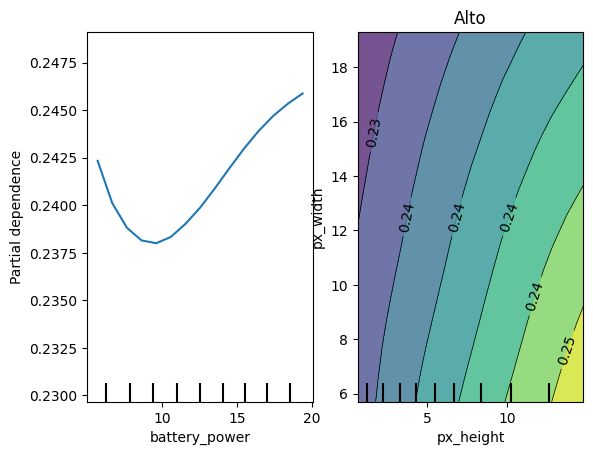


MLPClassifier 2:


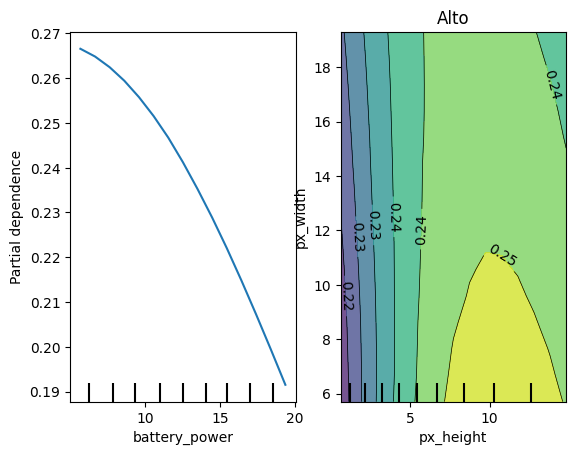


------------------------------------------------------------
------------------------------------------------------------

MLPClassifier 1:


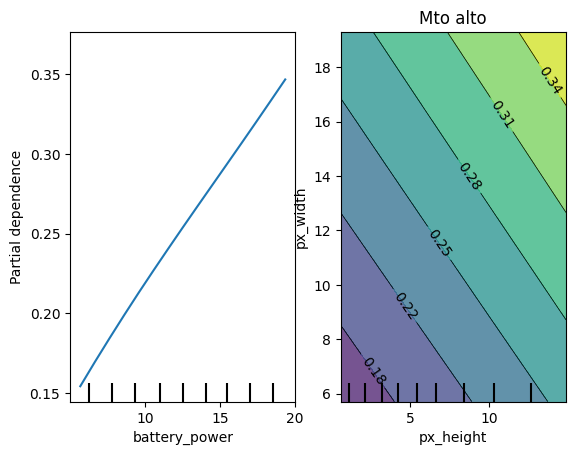


MLPClassifier 2:


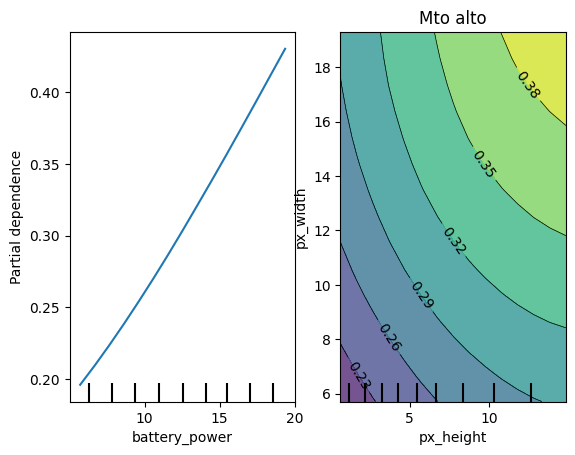


------------------------------------------------------------
------------------------------------------------------------


In [468]:
pdp2versions((mlp, mlp2), (X_ntrain, X_ntrain2), [0, (11, 12)], res=15)

---


DecisionTreeClassifier 1:


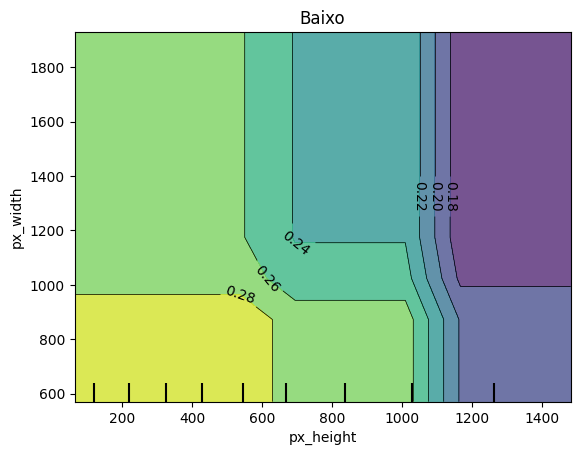


RandomForestClassifier 2:


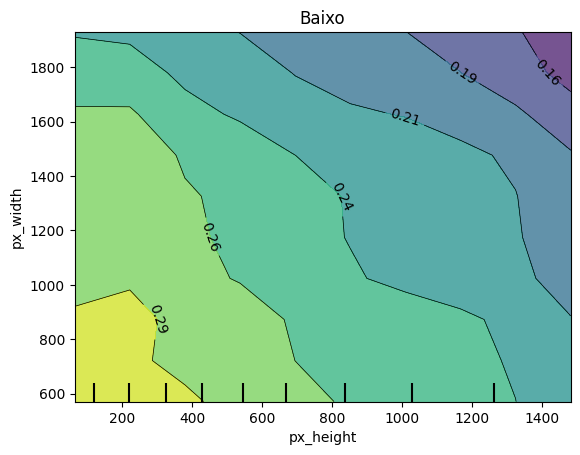


KNeighborsClassifier 3:


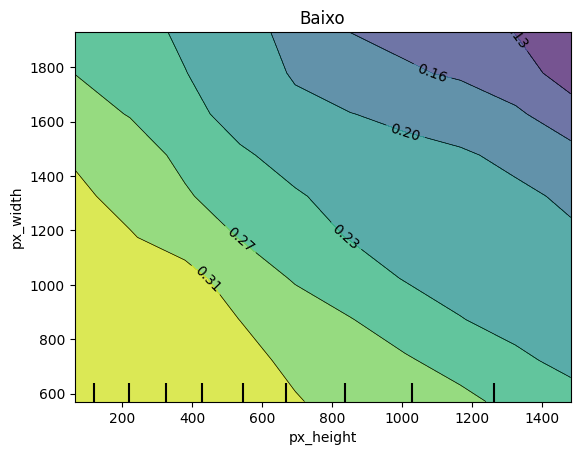


MLPClassifier 4:


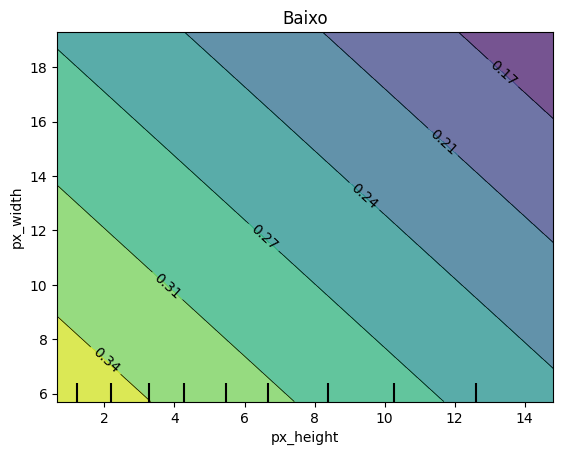


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


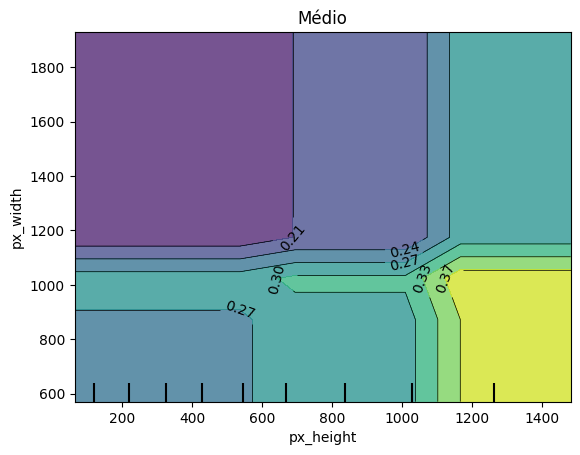


RandomForestClassifier 2:


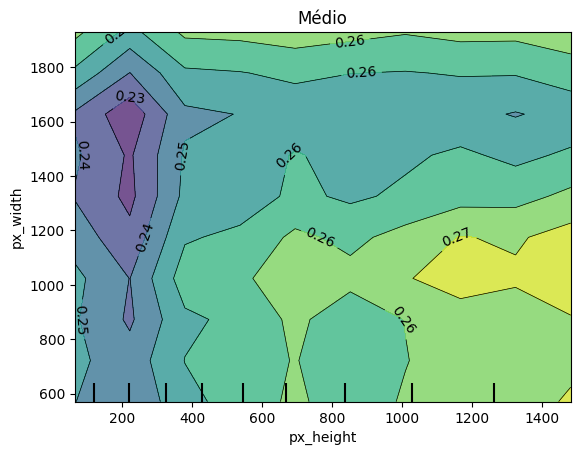


KNeighborsClassifier 3:


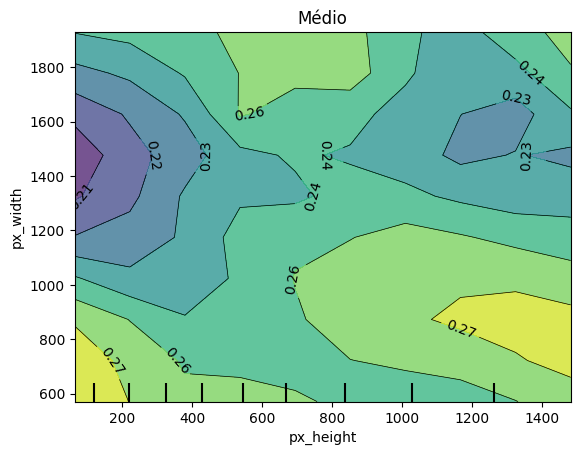


MLPClassifier 4:


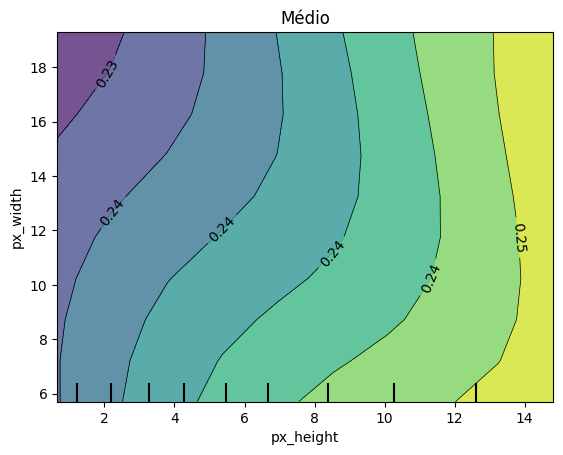


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


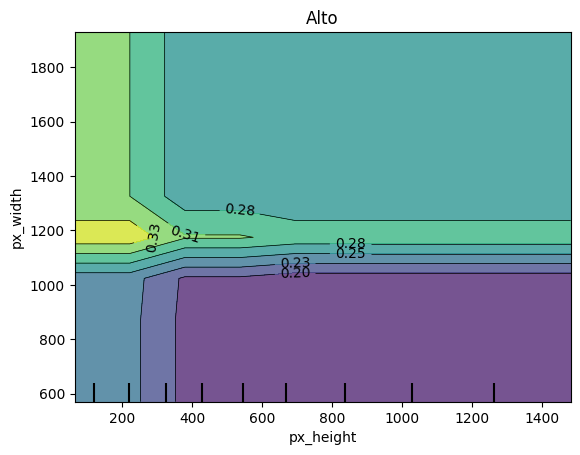


RandomForestClassifier 2:


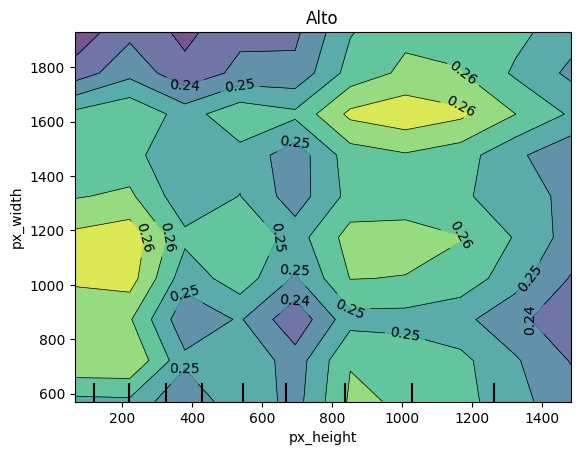


KNeighborsClassifier 3:


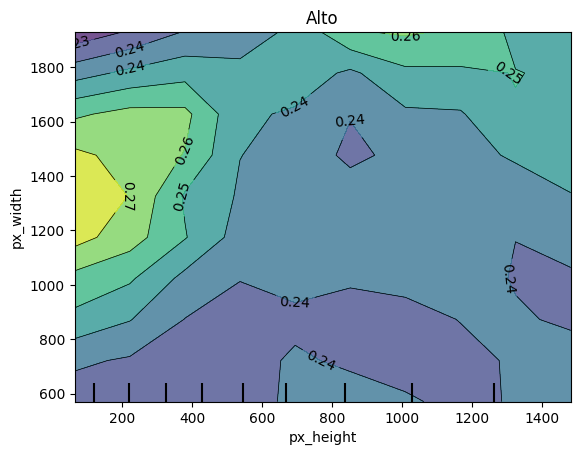


MLPClassifier 4:


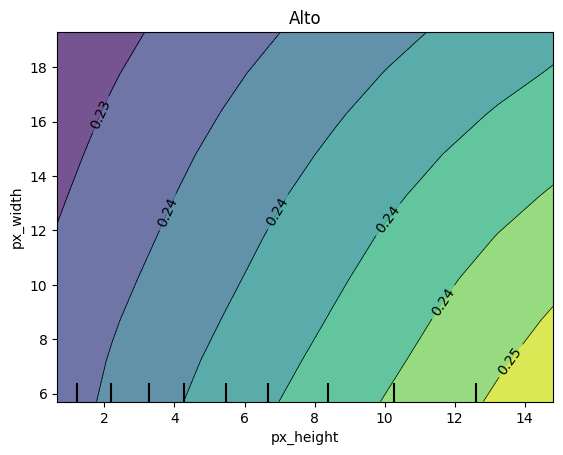


------------------------------------------------------------
------------------------------------------------------------

DecisionTreeClassifier 1:


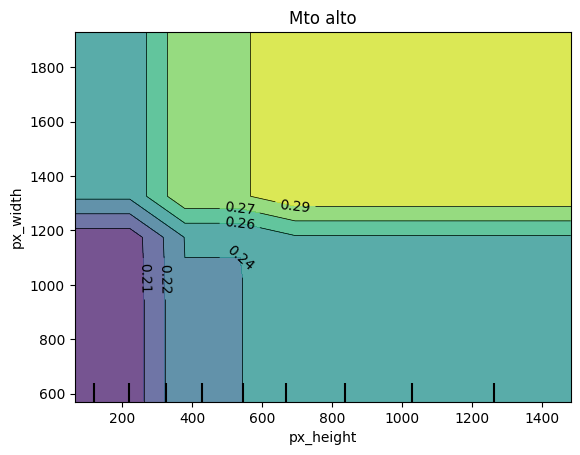


RandomForestClassifier 2:


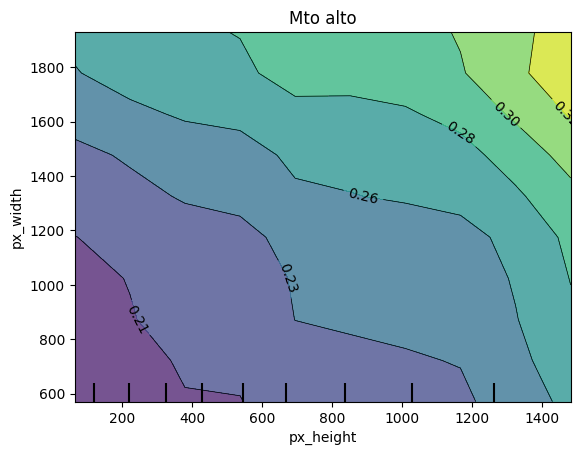


KNeighborsClassifier 3:


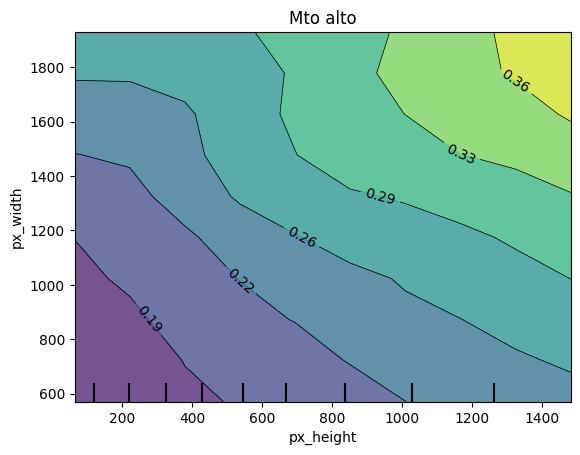


MLPClassifier 4:


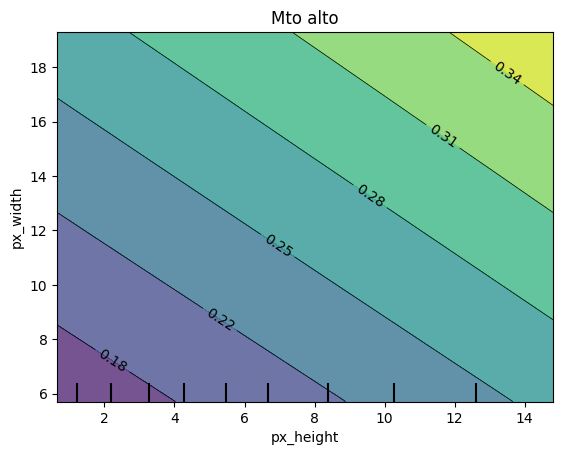


------------------------------------------------------------
------------------------------------------------------------


In [469]:
pdp2versions((dtree, rforest, knn, mlp), [X_train, X_train, X_train, X_ntrain], [(11, 12)])

---
---
# Incertezas

In [549]:
probpool = ProbPoolArray(NUM_SAMPLES, base_list=probpool.list_prob)
probpool2 = ProbPoolArray(NUM_SAMPLES, base_list=probpool2.list_prob)
probpool3 = ProbPoolArray(NUM_SAMPLES, base_list=probpool3.list_prob)

In [560]:
randomica = probpool.expcEntropy(df=True)
epistemica = probpool.predEntropy(df=True)

In [561]:
randomica = pd.concat([X_test.reset_index(drop=True), randomica, y_test.reset_index(drop=True)], axis=1)

In [562]:
randomica.sort_values('entropia', ascending=False)
#randomica[randomica['entropia'] > 0.5]

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
104            685     0          0.5         1   8       1          13   
423            622     0          0.7         0   0       1           9   
241           1961     1          1.5         0  10       0          55   
299            843     0          1.3         1   1       0          16   
256            539     1          0.6         1   9       0          21   
..             ...   ...          ...       ...  ..     ...         ...   
52             605     0          1.0         0   8       1           9   
144           1092     1          0.5         1  10       0          11   
63             909     1          0.5         1   9       0          30   
138           1976     1          0.7         1   4       0          32   
278           1591     1          2.2         0   3       1          49   

     m_dep  mobile_wt  n_cores  ...  px_width   ram  sc_h  sc_w  talk_time  \
104    0.8         82        7  ...      1203  3210    15     7          2   
423    0.3        127        2  ...       511  3916    13     1          5   
241    0.5        100        7  ...      1888  2355    14     7          6   
299    0.9        119        7  ...       732  1734    17     8         14   
256    0.1        145        7  ...       599  3597    14     5          9   
..     ...        ...      ...  ...       ...   ...   ...   ...        ...   
52     0.1        142        3  ...      1026   392    15     6          4   
144    0.5        167        3  ...       571   737    14     4         11   
63     0.4         97        3  ...       773   594    12     0          4   
138    0.8        171        2  ...      1922  3699    17    11         13   
278    0.4        154        6  ...      1883  3703    17     6         20   

     three_g  touch_screen  wifi  entropia  price_range  
104        1             1     1  1.164740            3  
423        1             0     1  1.158218            2  
241        1             1     1  1.155577            3  
299        0             0     1  1.155490            1  
256        0             0     0  1.148968            2  
..       ...           ...   ...       ...          ...  
52         1             0     0  0.169067            0  
144        0             1     0  0.167415            0  
63         1             1     1  0.162187            0  
138        0             1     1  0.145018            3  
278        1             1     0  0.143637            3  

[500 rows x 22 columns]

# **Análise e Conclusão**